In [22]:
from glob import glob
import pandas as pd
import argparse
import numpy as np
import os
from tqdm import tqdm
import itertools
import shutil

In [23]:
def read_file(f, baseline = False, dime_override = None):
    if baseline: 
        collection, retrieval_model, dime, _ = f.rsplit("/", 1)[1].rsplit(".")[0].split("_")
    else: 
        collection, retrieval_model, dime, _ , _ = f.rsplit("/", 1)[1].rsplit(".")[0].split("_")
    dime = dime_override if dime_override else dime  # Overwrite 'dime' if provided
    df = pd.read_csv(f, dtype={"query_id": str})
    df[["collection", "retrieval_model", "dime"]] = collection, retrieval_model, dime
    return df

## File management of topk best configuration

This section is for the code use to move all the csv related to a th-best configuration in the appropriate output_folder

In [3]:
### i want to create a structure like: 
# > data/experiments_finale
# >> (nth)best_result
# >>> baseline
# >>> eclipse_filter
# >>>>> llm
# >>>>> prf 

def create_folders(k, dir_path = 'data/experiments_finale'):
    ## ---  main folders ---
    parent_directories = ["best_results", "second_best_results", "third_best_results"] + [f"{i}th_best_results" for i in range(4, k+1)]
    
    dir_path_update = []
    for folder_name in parent_directories:
        ## create
        folder_name = os.path.join(dir_path, folder_name)
        os.makedirs(folder_name, exist_ok=True) 
        ## save
        print(f"Created folder: {folder_name}")
        dir_path_update.append(folder_name)
    
    for folder_name in dir_path_update:
        os.makedirs(os.path.join(folder_name, 'eclipse'), exist_ok=True) 
        os.makedirs(os.path.join(folder_name, 'eclipse/llm'), exist_ok=True) 
        os.makedirs(os.path.join(folder_name, 'eclipse/prf'), exist_ok=True)
        print(f"Created folder: {os.listdir(folder_name)}")

#create_folders(k=50, dir_path = 'data/experiments_finale')

In [4]:
dir_path = 'data/experiments_finale'
second_dir = 'best_results_update'
os.makedirs(os.path.join(dir_path, second_dir), exist_ok=True) 
os.makedirs(os.path.join(os.path.join(dir_path, second_dir), 'eclipse'), exist_ok=True) 
os.makedirs(os.path.join(os.path.join(dir_path, second_dir), 'eclipse/llm'), exist_ok=True) 
os.makedirs(os.path.join(os.path.join(dir_path, second_dir), 'eclipse/prf'), exist_ok=True)
os.makedirs(os.path.join(os.path.join(dir_path, second_dir), 'concat_results'), exist_ok=True)
os.makedirs(os.path.join(os.path.join(dir_path, second_dir), 'significance'), exist_ok=True)

We have two folders: 

- Eclipse LLM -> performance_gpt & performance_gpt_2
- Eclipse PRF -> performance_noise & performance_prf

In [3]:
def read_file_v0(f):
    collection, retrieval_model, dime, _ , config_id = f.rsplit("/", 1)[1].rsplit(".")[0].split("_")
    df = pd.read_csv(f, dtype={"query_id": str})
    ## llm constrain
    dime = 'Noise2' if ('performance_gpt_2' in f) or ('performance_prf' in f) else 'Noise1'
    df[["collection", "retrieval_model", "dime"]] = collection, retrieval_model, dime + '_' + config_id
    return df

In [4]:
def load_perf_prf(account_for_revision = False):
    path_to_csv = 'data/performance/performance_noise'
    dimes = ['Noise1']
    measures = ['AP', 'nDCG@10']
    alphas = np.arange(0.1, 1.1, .1).round(3)

    ## retrieve all the files in the experiment folder
    fn = list(filter(lambda x: np.any([d in x for d in dimes]), glob(f"{path_to_csv}/*.csv")))
    perf1 = pd.concat([read_file_v0(f) for f in fn])
    perf1 = perf1.loc[(perf1.measure.isin(measures)) & (perf1.alpha.isin(alphas))]

    if account_for_revision: 
        path_to_csv = 'data/performance/performance_prf'
        ## retrieve all the files in the experiment folder
        fn = list(filter(lambda x: np.any([d in x for d in dimes]), glob(f"{path_to_csv}/*.csv")))
        perf2 = pd.concat([read_file_v0(f) for f in fn])
        perf2 = perf2.loc[(perf2.measure.isin(measures)) & (perf2.alpha.isin(alphas))]

        perf = pd.concat([perf1, perf2], axis=0, ignore_index=True)
    else:
        perf = perf1
    ## average all the query for the mean_value metric
    average_perf = perf.groupby(['collection', 'retrieval_model', 'dime', 'measure', 'alpha']).value.agg('mean').reset_index()
    average_perf = average_perf.sort_values(by=['value'], ascending=False)
    return average_perf


def load_perf_llm(account_for_revision = False):
    path_to_csv = 'data/performance/performance_gpt'
    dimes = ['Noise1']
    measures = ['AP', 'nDCG@10']
    alphas = np.arange(0.1, 1.1, .1).round(3)

    ## retrieve all the files in the experiment folder
    fn = list(filter(lambda x: np.any([d in x for d in dimes]), glob(f"{path_to_csv}/*.csv")))
    perf1 = pd.concat([read_file_v0(f) for f in fn])
    perf1 = perf1.loc[(perf1.measure.isin(measures)) & (perf1.alpha.isin(alphas))]

    if account_for_revision:
        path_to_csv = 'data/performance/performance_gpt_2'
        ## retrieve all the files in the experiment folder
        fn = list(filter(lambda x: np.any([d in x for d in dimes]), glob(f"{path_to_csv}/*.csv")))
        perf2 = pd.concat([read_file_v0(f) for f in fn])
        perf2 = perf2.loc[(perf2.measure.isin(measures)) & (perf2.alpha.isin(alphas))]

        perf = pd.concat([perf1, perf2], axis=0, ignore_index=True)
    else:
        perf = perf1
    ## average all the query for the mean_value metric
    average_perf = perf.groupby(['collection', 'retrieval_model', 'dime', 'measure', 'alpha']).value.agg('mean').reset_index()
    average_perf = average_perf.sort_values(by=['value'], ascending=False)
    return average_perf

In [5]:
## retrieve the average performance for prf and llm experiments
average_perf_PRF = load_perf_prf(True)
average_perf_LLM = load_perf_llm(True)


## retrieve the average performance for prf and llm experiments (only old data)
#average_perf_PRF = load_perf_prf(False)
#average_perf_LLM = load_perf_llm(True)

RQ1 - MAIN RESULTS - VIS

In [26]:
## visualize 
def visualize_best_configurations(data, k=5):
    '''return the best k configuration'''
    grouped_data = data.groupby(['collection', 'retrieval_model',  'measure']).head(k)
    grouped_data = grouped_data.set_index(['collection', 'retrieval_model',  'measure']).sort_index()
    return grouped_data

k=1
best_PRF = visualize_best_configurations(average_perf_PRF, k=k)
best_PRF.loc[:, 'dime'] = 'eclipse-prf'
best_LLM = visualize_best_configurations(average_perf_LLM, k=k)
best_LLM.loc[:, 'dime'] = 'eclipse-llm'

# ex. best_PRF.xs(('deeplearning19'))

In [27]:
merge_df = pd.concat([best_PRF.drop(columns=['alpha']), best_LLM.drop(columns=['alpha'])])
merge_df = merge_df.reset_index().set_index(['collection', 'retrieval_model', 'measure', 'dime']).unstack(['collection', 'measure']).round(3)
dime_order = ["eclipse-prf",  "eclipse-llm"]
merge_df = merge_df.reindex(pd.MultiIndex.from_product([
                merge_df.index.levels[0],  # 'retrieval_model' level
                dime_order           # 'dime' level in the desired order
            ], names=merge_df.index.names))

merge_df

value                                 \
collection                  deeplearning19         deeplearning20           
measure                                 AP nDCG@10             AP nDCG@10   
retrieval_model dime                                                        
ance            eclipse-prf          0.406   0.669          0.408   0.656   
                eclipse-llm          0.424   0.706          0.411   0.665   
contriever      eclipse-prf          0.542   0.710          0.509   0.720   
                eclipse-llm          0.557   0.751          0.515   0.706   
tasb            eclipse-prf          0.550   0.745          0.509   0.726   
                eclipse-llm          0.557   0.775          0.511   0.711   

                                                                     
collection                  deeplearninghd         robust04          
measure                                 AP nDCG@10       AP nDCG@10  
retrieval_model dime                                                 
ance            eclipse-prf          0.193   0.349    0.179   0.402  
                eclipse-llm          0.210   0.360    0.168   0.430  
contriever      eclipse-prf          0.275   0.410    0.267   0.501  
                eclipse-llm          0.275   0.397    0.263   0.526  
tasb            eclipse-prf          0.278   0.420    0.232   0.460  
                eclipse-llm          0.283   0.423    0.222   0.475

In [39]:
#k=1
#dir_path_and_nth = [("best_results", 0), ('second_best_results', 1), ('third_best_results', 2)] + [(f"{i}th_best_results", i-1) for i in range(4, k+1)]

def compute_filename(folder_path, tupla, src=True, prf=None):
    collection, retrieval_model, dime, measure = tupla
    dime, config = dime.split('_')
    if prf: 
        folder_path = 'data/performance/performance_prf' if (src) & (dime == 'Noise2') else folder_path
    else: 
        folder_path = 'data/performance/performance_gpt_2' if (src) & (dime == 'Noise2') else folder_path
    filepath = f"{collection}_{retrieval_model}_Noise1_{measure}_{config}.csv"
    return os.path.join(folder_path, filepath)

def over_copy(src, dst):
    try:
        shutil.copyfile(src, dst)
    except shutil.SameFileError:
        pass


dir_path_and_nth = [('best_results_update', 0)]

#paths = []
#dst_paths = []
for dir_path, k in dir_path_and_nth:
## retrieve the second best for every experiment
    ids = average_perf_PRF.groupby(['collection', 'retrieval_model',  'measure']).nth(k).sort_index()
    ids = ids.set_index(['collection', 'retrieval_model', 'dime', 'measure']).index
    for tupla in ids: 
        src_filepath = compute_filename('data/performance/performance_noise', tupla, src=True, prf=True)
        dst_filepath = compute_filename(f'data/experiments_finale/{dir_path}/eclipse/prf', tupla, src=False, prf=True)
        #paths.append(src_filepath)
        over_copy(src_filepath, dst_filepath)


for dir_path, k in dir_path_and_nth:
## retrieve the second best for every experiment
    ids = average_perf_LLM.groupby(['collection', 'retrieval_model',  'measure']).nth(k).sort_index()
    ids = ids.set_index(['collection', 'retrieval_model', 'dime', 'measure']).index
    for tupla in ids: 
        src_filepath = compute_filename('data/performance/performance_gpt', tupla, src=True, prf=False)
        dst_filepath = compute_filename(f'data/experiments_finale/{dir_path}/eclipse/llm', tupla, src=False, prf=False)
        over_copy(src_filepath, dst_filepath)

## Aggregate the results

In [42]:
def load_experiments_results(path_to_csv, 
                             dimes = ['Noise'], 
                             dime_overwrite = None, 
                             baseline = False,
                             measures = ['nDCG@10', 'AP'], 
                             alphas = np.arange(0.1, 1.1, 0.1).round(3), 
                             filename = '',
                             path_to_folder = 'data/experiments_finale/best_results',
                             save = True):
    
    ## retrieve all the files in the experiment folder
    fn = list(filter(lambda x: np.any([d in x for d in dimes]), glob(f"{path_to_csv}/*.csv")))
    perf = pd.concat([read_file(f, baseline, dime_overwrite) for f in fn])
    perf = perf.loc[(perf.measure.isin(measures)) & (perf.alpha.isin(alphas))]
    # save to
    if save:
        os.makedirs(os.path.join(path_to_folder, 'concat_results'), exist_ok=True)
        perf.to_csv(os.path.join(path_to_folder, f'concat_results/{filename}'), index=False)
    return 

In [43]:
#k=50
#dir_path = ["best_results", 'second_best_results', 'third_best_results'] + [f"{i}th_best_results" for i in range(4, k+1)]

dir_path = ['best_results_update']
for folder_config in dir_path: 
    path_to_experiments = f'data/experiments_finale/{folder_config}'
    csv_path = f'data/experiments_finale/{folder_config}/concat_results'


    path_baseline_experiments = os.path.join(path_to_experiments, 'baselines')
    path_eclipse_experiments = os.path.join(path_to_experiments, 'eclipse')

    load_experiments_results(path_baseline_experiments, dimes = ['GPTFilter'], dime_overwrite = 'dime-llm', baseline = True, filename='DIME_llm.csv', path_to_folder = path_to_experiments)
    load_experiments_results(path_baseline_experiments, dimes = ['TopkFilter'],dime_overwrite = 'dime-prf', baseline = True, filename='DIME_prf.csv', path_to_folder = path_to_experiments)
    load_experiments_results(path_baseline_experiments, dimes = ['TopkFilter'],dime_overwrite = 'baseline', baseline = True, filename='baseline.csv', alphas=[1.], path_to_folder = path_to_experiments)
    load_experiments_results(os.path.join(path_eclipse_experiments, 'llm'), dimes = ['Noise1'], dime_overwrite = 'eclipse-llm', filename='ECLIPSE_llm.csv', path_to_folder = path_to_experiments)
    load_experiments_results(os.path.join(path_eclipse_experiments, 'prf'), dimes = ['Noise1'], dime_overwrite = 'eclipse-prf', filename='ECLIPSE_prf.csv', path_to_folder = path_to_experiments)

## Significance test

In [3]:
from scipy import stats

def print_test_results(statistic, p_value):
    print(f"\t\t\tTest statistic:{statistic}")
    print(f"\t\t\tP-value:{p_value}")

def check_significance(p_value, alphas = [0.01,0.05,0.1]):
    for alpha in alphas:
        significant = p_value<alpha
        if significant:
            break
    #print(f"\t\t\t--> The test is{'' if significant else ' NOT'} significant at {alpha} level")
    return alpha if significant else None

# Perform the Shapiro-Wilk test for normality.
# The Shapiro-Wilk test tests the null hypothesis that the data was drawn from a normal distribution.
def shapiro_test(sample, alphas = [0.01,0.05,0.1]):
    statistic, p_value = stats.shapiro(sample)
    print(f"\t\tShapiro-Wilk test for normality:")
    print_test_results(statistic, p_value)
    significance = check_significance(p_value, alphas)
    print()
    return significance

# Calculate the T-test for the mean of ONE group of scores OR on TWO RELATED samples of scores.
# The first one is a test for the null hypothesis that the expected value (mean) of a sample of independent observations is equal to the given population mean
# The second one is a test for the null hypothesis that two related or repeated samples have identical average (expected) values.
def t_test(sample1, sample2=None, pop_mean=0, alternative = "less", alphas = [0.01,0.05,0.1]):
    if sample2 is None:
        #print(f"\t\tT-test for the mean of ONE group of scores with population mean {pop_mean} and {alternative} alternative:")
        statistic, p_value = stats.ttest_1samp(sample1, popmean=pop_mean, alternative=alternative)
    else:
        #print(f"\t\tT-test for the mean of TWO RELATED samples of scores with {alternative} alternative:")
        statistic, p_value = stats.ttest_rel(sample1, sample2, alternative=alternative)
    #print_test_results(statistic, p_value)
    significance = check_significance(p_value, alphas)
    #print()
    return significance

# Calculate the Wilcoxon signed-rank test.
# The Wilcoxon signed-rank test tests the null hypothesis that two related paired samples come from the same distribution.
# In particular, it tests whether the distribution of the differences x - y is symmetric about zero.
# It is a non-parametric version of the paired T-test.
def wilcoxon_test(sample1, sample2=None, alternative = "greater", alphas = [0.01,0.05,0.1], zero_method = ["wilcox", "pratt", "zsplit"]):
    significance = []
    if isinstance(zero_method,str):
        zero_method = [zero_method]
    for zero_method in zero_method:
        #print(f"\t\tWilcoxon signed-rank test with {zero_method} method and {alternative} alternative:")
        statistic, p_value = stats.wilcoxon(sample1, sample2, zero_method=zero_method, correction=False, alternative=alternative)
        #print_test_results(statistic, p_value)
        significance.append(check_significance(p_value, alphas))
    #print()
    return significance

In [4]:
from statsmodels.stats.multitest import multipletests as mult_test

### HOLM-BONFERRONI CORRECTION
# Calculate the T-test for the mean of ONE group of scores OR on TWO RELATED samples of scores.
# The first one is a test for the null hypothesis that the expected value (mean) of a sample of independent observations is equal to the given population mean
# The second one is a test for the null hypothesis that two related or repeated samples have identical average (expected) values.
def t_test_HB(sample1, sample2=None, pop_mean=0, alternative = "less", alphas = [0.01,0.05,0.1]):
    if sample2 is None:
        statistic, p_value = stats.ttest_1samp(sample1, popmean=pop_mean, alternative=alternative)
    else:
        statistic, p_value = stats.ttest_rel(sample1, sample2, alternative=alternative)
    return p_value

# Calculate the Wilcoxon signed-rank test.
# The Wilcoxon signed-rank test tests the null hypothesis that two related paired samples come from the same distribution.
# In particular, it tests whether the distribution of the differences x - y is symmetric about zero.
# It is a non-parametric version of the paired T-test.
def wilcoxon_test_HB(sample1, sample2=None, alternative = "greater", alphas = [0.01,0.05,0.1], zero_method = ["wilcox", "pratt", "zsplit"]):
    significance = []
    if isinstance(zero_method,str):
        zero_method = [zero_method]
    for zero_method in zero_method:
        statistic, p_value = stats.wilcoxon(sample1, sample2, zero_method=zero_method, correction=False, alternative=alternative)
    return p_value

## Build the main table

In [77]:
def improvement(finale, iniziale):
    return (finale-iniziale)/iniziale*100

In [78]:
## stack all the dataframe in one
## this dataframe contain the sample results, i.e. a metric for every single queries
#csv_path = 'data/experiments_finale/best_results_update/concat_results'

csv_path = 'data/experiments_finale/best_results_update/concat_results'
fn = glob(f"{csv_path}/*.csv")    
perf = pd.concat([pd.read_csv(f) for f in fn])

## aggregate 'mean' the queries @alpha e configurazione (collection, model, filter, measure)
average_perf = perf.groupby(['collection', 'retrieval_model', 'dime', 'measure', 'alpha']).value.agg('mean')

In [79]:
## visualize the maximum value with the corresponding alpha
df_unstacked = average_perf.unstack('alpha')
max_values = df_unstacked.max(axis=1)
max_alpha = df_unstacked.idxmax(axis=1)
max_perf_with_alpha_v0 = pd.DataFrame({'max_value': max_values, 'alpha': max_alpha}).reset_index()
max_perf_with_alpha_v1 = max_perf_with_alpha_v0.set_index(['collection', 'retrieval_model', 'dime', 'measure', 'alpha'])

data = max_perf_with_alpha_v1.unstack(['measure'])['max_value']

RQ1 - MAIN VIS

In [80]:
#### ==== TABELA FINALE =====
max_tabella = max_perf_with_alpha_v0.set_index(['collection', 'retrieval_model', 'dime', 'measure'])
data = max_tabella.unstack(['measure'])['max_value']
visualization_table = data.reset_index().set_index(['collection', 'retrieval_model', 'dime']).unstack('collection').swaplevel(0,1, axis=1).sort_index(level=0, axis=1)
dime_order = ["baseline", "dime-prf", "dime-llm", "eclipse-prf", "eclipse-llm" ]
visualization_table = visualization_table.reindex(pd.MultiIndex.from_product([
                                                    visualization_table.index.levels[0],  # 'retrieval_model' level
                                                    dime_order           # 'dime' level in the desired order
                                                ], names=visualization_table.index.names))
visualization_table.round(3)

collection                  deeplearning19         deeplearning20          \
measure                                 AP nDCG@10             AP nDCG@10   
retrieval_model dime                                                        
ance            baseline             0.361   0.645          0.392   0.646   
                dime-prf             0.370   0.657          0.392   0.649   
                dime-llm             0.370   0.663          0.397   0.658   
                eclipse-prf          0.406   0.669          0.408   0.656   
                eclipse-llm          0.424   0.706          0.411   0.665   
contriever      baseline             0.494   0.677          0.478   0.666   
                dime-prf             0.509   0.692          0.496   0.713   
                dime-llm             0.523   0.745          0.505   0.697   
                eclipse-prf          0.542   0.710          0.509   0.720   
                eclipse-llm          0.557   0.751          0.515   0.706   
tasb            baseline             0.476   0.719          0.475   0.685   
                dime-prf             0.507   0.731          0.489   0.712   
                dime-llm             0.527   0.768          0.496   0.705   
                eclipse-prf          0.550   0.745          0.509   0.726   
                eclipse-llm          0.557   0.775          0.511   0.711   

collection                  deeplearninghd         robust04          
measure                                 AP nDCG@10       AP nDCG@10  
retrieval_model dime                                                 
ance            baseline             0.180   0.334    0.146   0.384  
                dime-prf             0.184   0.340    0.150   0.386  
                dime-llm             0.186   0.346    0.149   0.397  
                eclipse-prf          0.193   0.349    0.179   0.402  
                eclipse-llm          0.210   0.360    0.168   0.430  
contriever      baseline             0.241   0.375    0.239   0.481  
                dime-prf             0.251   0.388    0.253   0.486  
                dime-llm             0.263   0.396    0.263   0.527  
                eclipse-prf          0.275   0.410    0.267   0.501  
                eclipse-llm          0.275   0.397    0.263   0.526  
tasb            baseline             0.238   0.374    0.197   0.428  
                dime-prf             0.244   0.385    0.215   0.444  
                dime-llm             0.265   0.408    0.218   0.471  
                eclipse-prf          0.278   0.420    0.232   0.460  
                eclipse-llm          0.283   0.423    0.222   0.475

In [81]:
print(visualization_table.round(3).style.format(precision=3).to_latex())

\begin{tabular}{llrrrrrrrr}
 & collection & \multicolumn{2}{r}{deeplearning19} & \multicolumn{2}{r}{deeplearning20} & \multicolumn{2}{r}{deeplearninghd} & \multicolumn{2}{r}{robust04} \\
 & measure & AP & nDCG@10 & AP & nDCG@10 & AP & nDCG@10 & AP & nDCG@10 \\
retrieval_model & dime &  &  &  &  &  &  &  &  \\
\multirow[c]{5}{*}{ance} & baseline & 0.361 & 0.645 & 0.392 & 0.646 & 0.180 & 0.334 & 0.146 & 0.384 \\
 & dime-prf & 0.370 & 0.657 & 0.392 & 0.649 & 0.184 & 0.340 & 0.150 & 0.386 \\
 & dime-llm & 0.370 & 0.663 & 0.397 & 0.658 & 0.186 & 0.346 & 0.149 & 0.397 \\
 & eclipse-prf & 0.406 & 0.669 & 0.408 & 0.656 & 0.193 & 0.349 & 0.179 & 0.402 \\
 & eclipse-llm & 0.424 & 0.706 & 0.411 & 0.665 & 0.210 & 0.360 & 0.168 & 0.430 \\
\multirow[c]{5}{*}{contriever} & baseline & 0.494 & 0.677 & 0.478 & 0.666 & 0.241 & 0.375 & 0.239 & 0.481 \\
 & dime-prf & 0.509 & 0.692 & 0.496 & 0.713 & 0.251 & 0.388 & 0.253 & 0.486 \\
 & dime-llm & 0.523 & 0.745 & 0.505 & 0.697 & 0.263 & 0.396 & 0.263 & 0.527 

Improvement section

In [88]:
print(data.unstack('dime')['AP'].apply(lambda x: improvement(x.loc['eclipse-llm'], x.loc['baseline']), axis=1))
print()
print(data.unstack('dime')['AP'].apply(lambda x: improvement(x.loc['eclipse-prf'], x.loc['baseline']), axis=1))
print('==========================')

print(data.unstack('dime')['nDCG@10'].apply(lambda x: improvement(x.loc['eclipse-llm'], x.loc['dime-prf']), axis=1))

collection      retrieval_model
deeplearning19  ance               17.428591
                contriever         12.874864
                tasb               17.009762
deeplearning20  ance                4.761038
                contriever          7.568231
                tasb                7.389230
deeplearninghd  ance               16.570192
                contriever         14.005231
                tasb               18.892487
robust04        ance               15.201757
                contriever         10.198802
                tasb               12.347931
dtype: float64

collection      retrieval_model
deeplearning19  ance               12.362233
                contriever          9.781638
                tasb               15.463359
deeplearning20  ance                3.995661
                contriever          6.441139
                tasb                7.111392
deeplearninghd  ance                6.900804
                contriever         14.040036
                tasb

In [90]:
print(data.unstack('dime')['AP'].apply(lambda x: improvement(x.loc['eclipse-llm'], x.loc['dime-prf']), axis=1))
print()
print(data.unstack('dime')['AP'].apply(lambda x: improvement(x.loc['eclipse-llm'], x.loc['dime-llm']), axis=1))
print()
print(data.unstack('dime')['AP'].apply(lambda x: improvement(x.loc['eclipse-prf'], x.loc['dime-prf']), axis=1))
print()

collection      retrieval_model
deeplearning19  ance               14.544843
                contriever          9.583527
                tasb                9.885210
deeplearning20  ance                4.661523
                contriever          3.790083
                tasb                4.363714
deeplearninghd  ance               13.915852
                contriever          9.781670
                tasb               16.307523
robust04        ance               12.518147
                contriever          4.157112
                tasb                2.947830
dtype: float64

collection      retrieval_model
deeplearning19  ance               14.484886
                contriever          6.664653
                tasb                5.666118
deeplearning20  ance                3.511225
                contriever          2.010907
                tasb                2.903828
deeplearninghd  ance               13.176803
                contriever          4.782745
                tasb

In [91]:
print(data.unstack('dime')['nDCG@10'].apply(lambda x: improvement(x.loc['eclipse-llm'], x.loc['dime-prf']), axis=1))
print()
print(data.unstack('dime')['nDCG@10'].apply(lambda x: improvement(x.loc['eclipse-llm'], x.loc['dime-llm']), axis=1))
print()
print(data.unstack('dime')['nDCG@10'].apply(lambda x: improvement(x.loc['eclipse-prf'], x.loc['dime-prf']), axis=1))
print()

collection      retrieval_model
deeplearning19  ance                7.509169
                contriever          8.638844
                tasb                6.035529
deeplearning20  ance                2.497918
                contriever         -0.971751
                tasb               -0.186305
deeplearninghd  ance                6.034865
                contriever          2.497551
                tasb                9.967702
robust04        ance               11.424518
                contriever          8.388646
                tasb                7.146306
dtype: float64

collection      retrieval_model
deeplearning19  ance               6.395224
                contriever         0.831499
                tasb               0.913990
deeplearning20  ance               1.067911
                contriever         1.276678
                tasb               0.822096
deeplearninghd  ance               4.203473
                contriever         0.423479
                tasb        

In [89]:
print(data.unstack('dime')['nDCG@10'].apply(lambda x: improvement(x.loc['eclipse-llm'], x.loc['baseline']), axis=1))
print()
print(data.unstack('dime')['nDCG@10'].apply(lambda x: improvement(x.loc['eclipse-prf'], x.loc['baseline']), axis=1))
print('==========================')

collection      retrieval_model
deeplearning19  ance                9.407761
                contriever         11.040757
                tasb                7.804460
deeplearning20  ance                2.898843
                contriever          5.990972
                tasb                3.720199
deeplearninghd  ance                7.925930
                contriever          6.060974
                tasb               13.099539
robust04        ance               11.740082
                contriever          9.527603
                tasb               11.125926
dtype: float64

collection      retrieval_model
deeplearning19  ance                3.637902
                contriever          4.995446
                tasb                3.623173
deeplearning20  ance                1.447584
                contriever          8.085575
                tasb                5.914722
deeplearninghd  ance                4.497041
                contriever          9.415113
                tasb

### Stat sign

In [11]:
## statistical significance
shapiro_test_over_perf = perf.groupby(['collection', 'retrieval_model', 'dime', 'measure', 'alpha']).value.apply(shapiro_test)
shapiro_test_over_perf = shapiro_test_over_perf.rename('shapiro p-value')

		Shapiro-Wilk test for normality:
			Test statistic:0.961893076496417
			P-value:0.16257068137539116

		Shapiro-Wilk test for normality:
			Test statistic:0.9357382672102474
			P-value:0.018378666487228336

		Shapiro-Wilk test for normality:
			Test statistic:0.3035273464892613
			P-value:5.19271693454877e-13

		Shapiro-Wilk test for normality:
			Test statistic:0.47661650816254664
			P-value:3.482386204442012e-11

		Shapiro-Wilk test for normality:
			Test statistic:0.8431756586595154
			P-value:3.53192095116002e-05

		Shapiro-Wilk test for normality:
			Test statistic:0.9336578781702497
			P-value:0.015550031066018093

		Shapiro-Wilk test for normality:
			Test statistic:0.9573739006737813
			P-value:0.11107700757087507

		Shapiro-Wilk test for normality:
			Test statistic:0.9630932884247578
			P-value:0.17975302123157627

		Shapiro-Wilk test for normality:
			Test statistic:0.9692557123748332
			P-value:0.29799553152612746

		Shapiro-Wilk test for normality:
			Test statistic:0.963

In [12]:
## add the shapiro p-value to the configuration we want to test
max_perf_with_alpha_v1 = pd.merge(max_perf_with_alpha_v1, shapiro_test_over_perf, on = ['dime', 'collection', 'retrieval_model', 'measure', 'alpha'], how='left')

In [13]:
def convert_to_baseline(hypothesis):
    l = list(hypothesis)
    alpha = l.pop()
    l.append(1.)
    return tuple(l)

def decide_test(null_test, alternative_test):
    test = np.nan
    ## if both are not nan (= t-test) then t-test
    if not (np.isnan(null_test) and np.isnan(alternative_test)):
        test = 1
    return test

def apply_correction(pvals, alpha):
    reject, bonf = mult_test(pvals, method = "holm", alpha=alpha)[:2]
    return reject

def perform_stat_test(perf, 
                    alternative_dimes = ['eclipse-llm', 'eclipse-prf'],  ## accepted only one option tho
                    null_dimes=['baseline', 'dime-llm', 'dime-prf'],
                    alphas=[0.01, 0.05, 0.1],  num_test=None):

    ## fix alternative dime
    alternative_dime = alternative_dimes[0]

    perf_sign = {}
    perf_tmp = perf.set_index(['dime', 'collection', 'retrieval_model', 'measure', 'alpha']).sort_index().copy()

    ## if we need Holm-Bonferroni correction
    if len(null_dimes)==1:
        for null_dime in null_dimes:
            # retrieve all the configuration (collection , model, measure, best_alpha) that we need to test 
            hypothesis = max_perf_with_alpha_v1.xs((alternative_dime)).index
            for hyp in hypothesis: 
                ## retrieve the null and alternative samples
                if null_dime == 'baseline':  # just adjust since baseline is always 1.0 and tuple are immutable
                    null_hyp = convert_to_baseline(hyp)
                else: 
                    null_hyp = hyp
                alternative_sample = perf_tmp.xs((alternative_dime, ) + hyp).value.to_list()
                null_sample = perf_tmp.xs((null_dime, ) + null_hyp).value.to_list()

                ## here we need to decide which test to use
                alternative_test = max_perf_with_alpha_v1.xs((alternative_dime)).xs(hyp[:3])['shapiro p-value'].iloc[0]  # hyp[:3] since 'alpha' are different between alt and null
                null_test = max_perf_with_alpha_v1.xs((null_dime)).xs(null_hyp[:3])['shapiro p-value'].iloc[0]
                test = decide_test(null_test, alternative_test)

                if np.isnan(test):
                    # perform Wilxcon test
                    sign = wilcoxon_test(alternative_sample, sample2=null_sample, alternative = "greater", alphas = alphas, zero_method=['wilcox'])
                    sign = sign[0]
                else: 
                    # perform t-test
                    sign = t_test(alternative_sample, sample2=null_sample, alternative = "greater", alphas = alphas)
                perf_sign[(null_dime, alternative_dime, ) + hyp] = sign

        perf_sign = pd.Series(perf_sign).reset_index()
        perf_sign = perf_sign.rename(columns={'level_0': 'null_dime', 'level_1': 'alternative_dime',
                                        'level_2': 'collection', 'level_3': 'retrieval_model', 
                                        'level_4': 'measure', 0: 'sign-level'}).drop(columns = ['level_5'])


        perf_sign = perf_sign.set_index(['alternative_dime', 'collection', 'retrieval_model', 'measure', 'null_dime']).unstack()

    else: 
        for null_dime in null_dimes:
            # retrieve all the configuration (collection , model, measure, best_alpha) that we need to test 
            hypothesis = max_perf_with_alpha_v1.xs((alternative_dime)).index
            for hyp in hypothesis: 
                ## retrieve the null and alternative samples
                if null_dime == 'baseline':  # just adjust since baseline is always 1.0 and tuple are immutable
                    null_hyp = convert_to_baseline(hyp)
                else: 
                    null_hyp = hyp
                alternative_sample = perf_tmp.xs((alternative_dime, ) + hyp).value.to_list()
                null_sample = perf_tmp.xs((null_dime, ) + null_hyp).value.to_list()

                ## here we need to decide which test to use
                alternative_test = max_perf_with_alpha_v1.xs((alternative_dime)).xs(hyp[:3])['shapiro p-value'].iloc[0]  # hyp[:3] since 'alpha' are different between alt and null
                null_test = max_perf_with_alpha_v1.xs((null_dime)).xs(null_hyp[:3])['shapiro p-value'].iloc[0]
                test = decide_test(null_test, alternative_test)

                if np.isnan(test):
                    # perform Wilxcon test
                    p_value = wilcoxon_test_HB(alternative_sample, sample2=null_sample, alternative = "greater", alphas = alphas, zero_method=['wilcox'])
                else: 
                    # perform t-test
                    p_value = t_test_HB(alternative_sample, sample2=null_sample, alternative = "greater", alphas = alphas)
                perf_sign[(null_dime, alternative_dime, ) + hyp] = p_value

        perf_sign = pd.Series(perf_sign).reset_index()
        perf_sign = perf_sign.rename(columns={'level_0': 'null_dime', 'level_1': 'alternative_dime',
                                'level_2': 'collection', 'level_3': 'retrieval_model', 
                                'level_4': 'measure', 0: 'p_value'}).drop(columns = ['level_5'])
        
        pvals = perf_sign.groupby(['alternative_dime', 'collection', 'retrieval_model', 'measure']).p_value.apply(np.hstack)
        rejections = pvals.apply(lambda x: list(apply_correction(x, alpha=alphas[0]))).to_list()
        pvals = pvals.reset_index()
        pvals[['dime-prf', 'dime-llm']]=rejections
        perf_sign = pvals.set_index(['alternative_dime', 'collection', 'retrieval_model', 'measure'])[['dime-prf', 'dime-llm']]

    return perf_sign

def sign_visualization(perf_sign, colname):
    mask = max_perf_with_alpha_v1.index.get_level_values('dime').isin(['eclipse-prf', 'eclipse-llm'])
    max_perf_sign = pd.merge(max_perf_with_alpha_v1[mask].sort_values(['collection', 'retrieval_model','measure', 'dime']), 
                            perf_sign.rename_axis(index={'alternative_dime': 'dime'}).sort_values(['collection', 'retrieval_model','measure', 'dime'])[colname], 
                            on = ['collection', 'retrieval_model','measure', 'dime'],
                            how = 'left')

    max_perf_sign = max_perf_sign.unstack('measure')[['max_value', colname]]
    vis = max_perf_sign[colname].unstack(['collection']).swaplevel(0, 1, axis=1).sort_index(level=0, axis=1)
    dime_order = ["eclipse-prf",  "eclipse-llm"]
    vis = vis.reindex(pd.MultiIndex.from_product([
                    vis.index.levels[0],  # 'retrieval_model' level
                    dime_order           # 'dime' level in the desired order
                ], names=vis.index.names))
    return vis

In [14]:
perf_sign_llmvsbaseline = perform_stat_test(perf, alternative_dimes=['eclipse-llm'], null_dimes=['baseline'], alphas=[0.05])
perf_sign_prfvsbaseline = perform_stat_test(perf, alternative_dimes=['eclipse-prf'], null_dimes=['baseline'], alphas=[0.05])
perf_sign_baseline = pd.concat([perf_sign_llmvsbaseline, perf_sign_prfvsbaseline])
perf_sign_baseline.loc[:, 'significant_baseline'] = perf_sign_baseline['sign-level'].notna()#.iloc[:, 0]
sign_visualization(perf_sign_baseline, 'significant_baseline')

collection                  deeplearning19         deeplearning20          \
measure                                 AP nDCG@10             AP nDCG@10   
retrieval_model dime                                                        
ance            eclipse-prf           True   False           True    True   
                eclipse-llm           True    True           True   False   
contriever      eclipse-prf           True   False           True    True   
                eclipse-llm           True    True           True    True   
tasb            eclipse-prf           True    True           True    True   
                eclipse-llm           True    True           True    True   

collection                  deeplearninghd         robust04          
measure                                 AP nDCG@10       AP nDCG@10  
retrieval_model dime                                                 
ance            eclipse-prf           True   False     True    True  
                eclipse-llm           True   False     True    True  
contriever      eclipse-prf           True    True     True    True  
                eclipse-llm           True    True     True    True  
tasb            eclipse-prf           True    True     True    True  
                eclipse-llm           True    True     True    True

In [15]:
perf_sign_llmvsdime = perform_stat_test(perf, alternative_dimes=['eclipse-llm'], null_dimes=['dime-prf', 'dime-llm'], alphas=[0.05])
perf_sign_prfvsdime = perform_stat_test(perf, alternative_dimes=['eclipse-prf'], null_dimes=['dime-prf', 'dime-llm'], alphas=[0.05])
perf_sign_dime = pd.concat([perf_sign_llmvsdime, perf_sign_prfvsdime])
perf_sign_dime.loc[:, 'significant_dime'] = perf_sign_dime.all(axis=1)
sign_visualization(perf_sign_dime, 'significant_dime')

collection                  deeplearning19         deeplearning20          \
measure                                 AP nDCG@10             AP nDCG@10   
retrieval_model dime                                                        
ance            eclipse-prf          False   False          False   False   
                eclipse-llm           True    True           True   False   
contriever      eclipse-prf          False   False          False   False   
                eclipse-llm           True   False           True   False   
tasb            eclipse-prf           True   False           True    True   
                eclipse-llm           True    True           True   False   

collection                  deeplearninghd         robust04          
measure                                 AP nDCG@10       AP nDCG@10  
retrieval_model dime                                                 
ance            eclipse-prf           True   False     True    True  
                eclipse-llm          False   False     True    True  
contriever      eclipse-prf          False    True     True   False  
                eclipse-llm          False   False    False   False  
tasb            eclipse-prf           True    True     True   False  
                eclipse-llm           True    True    False   False

## Improvment TABELLA

In [40]:
alphas = [0.5]

eclipse_llm = pd.read_csv('data/experiments_finale/best_results_update/concat_results/ECLIPSE_llm.csv')
eclipse_llm = eclipse_llm[eclipse_llm.alpha.isin(alphas)]
average_eclipse_llm = eclipse_llm.groupby(['collection', 'retrieval_model', 'dime', 'measure', 'alpha']).value.agg('mean').reset_index()
average_eclipse_llm = average_eclipse_llm.sort_values(by=['value'], ascending=False)


dime_llm = pd.read_csv('data/experiments_finale/best_results_update/concat_results/DIME_llm.csv')
dime_llm = dime_llm[dime_llm.alpha.isin(alphas)]
average_dime_llm = dime_llm.groupby(['collection', 'retrieval_model', 'dime', 'measure', 'alpha']).value.agg('mean').reset_index()
average_dime_llm = average_dime_llm.sort_values(by=['value'], ascending=False)

eclipse_prf = pd.read_csv('data/experiments_finale/best_results_update/concat_results/ECLIPSE_prf.csv')
eclipse_prf = eclipse_prf[eclipse_prf.alpha.isin(alphas)]
average_eclipse_prf = eclipse_prf.groupby(['collection', 'retrieval_model', 'dime', 'measure', 'alpha']).value.agg('mean').reset_index()
average_eclipse_prf = average_eclipse_prf.sort_values(by=['value'], ascending=False)


dime_prf = pd.read_csv('data/experiments_finale/best_results_update/concat_results/DIME_prf.csv')
dime_prf = dime_prf[dime_prf.alpha.isin(alphas)]
average_dime_prf = dime_prf.groupby(['collection', 'retrieval_model', 'dime', 'measure', 'alpha']).value.agg('mean').reset_index()
average_dime_prf = average_dime_prf.sort_values(by=['value'], ascending=False)

In [41]:
indexes = ['collection', 'retrieval_model', 'dime', 'measure', 'alpha']

average_eclipse_llm = average_eclipse_llm.set_index(indexes).sort_index().unstack().unstack()
average_dime_llm = average_dime_llm.set_index(indexes).sort_index().unstack().unstack()
average_eclipse_prf = average_eclipse_prf.set_index(indexes).sort_index().unstack().unstack()
average_dime_prf = average_dime_prf.set_index(indexes).sort_index().unstack().unstack()

In [42]:
concat_df = pd.concat([average_dime_llm, average_eclipse_llm, average_eclipse_prf, average_dime_prf]).sort_index()

In [43]:
concat_df = concat_df['value'].xs((0.5), axis=1).unstack('collection').swaplevel(0, 1, axis=1)

In [44]:
indexing = list(itertools.product(['deeplearning19', 'deeplearning20', 'deeplearninghd', 'robust04'], ['AP', 'nDCG@10']))
concat_df = concat_df[indexing]

In [45]:
old_indexing = [[(0.1,'AP'), (0.2,'AP'), (0.3,'AP'), (0.4,'AP'), (0.5,'AP'),
            (0.1, 'nDCG@10'), (0.2,'nDCG@10'), (0.3, 'nDCG@10'), (0.4,'nDCG@10'), (0.5, 'nDCG@10')]]

In [46]:
#print(concat_df.round(4).style.format(precision=4).to_latex())

In [47]:
llm_improv = ((concat_df.xs(('eclipse-llm'), level=1).round(4) - concat_df.xs(('dime-llm'), level=1)).round(4) / concat_df.xs(('dime-llm'), level=1).round(4) * 100).round(4)
prf_improv = ((concat_df.xs(('eclipse-prf'), level=1).round(4) - concat_df.xs(('dime-prf'), level=1)).round(4) / concat_df.xs(('dime-prf'), level=1).round(4) * 100).round(4)

In [48]:
prf_improv.loc[:, 'dime'] = 'prf-improvement'
prf_improv = prf_improv.reset_index().set_index(['retrieval_model', 'dime'])

llm_improv.loc[:, 'dime'] = 'llm-improvement'
llm_improv = llm_improv.reset_index().set_index(['retrieval_model', 'dime'])

In [49]:
t2 = pd.concat([concat_df, llm_improv, prf_improv]).sort_index()
## reorder nicely
dime_order = ["dime-llm", "eclipse-llm", "llm-improvement", "dime-prf", "eclipse-prf", "prf-improvement"]
t2 = t2.reindex(pd.MultiIndex.from_product([
                t2.index.levels[0],  # 'retrieval_model' level
                dime_order           # 'dime' level in the desired order
            ], names=t2.index.names))

t2.round(4)

collection                      deeplearning19         deeplearning20          \
measure                                     AP nDCG@10             AP nDCG@10   
retrieval_model dime                                                            
ance            dime-llm                0.3238  0.6334         0.3427  0.5854   
                eclipse-llm             0.3949  0.6863         0.3725  0.6124   
                llm-improvement        21.9580  8.3518         8.6957  4.6122   
                dime-prf                0.3156  0.6251         0.3382  0.6057   
                eclipse-prf             0.3751  0.6462         0.3766  0.6164   
                prf-improvement        18.8530  3.3755        11.3542  1.7666   
contriever      dime-llm                0.5207  0.7367         0.5007  0.6933   
                eclipse-llm             0.5572  0.7436         0.5104  0.6957   
                llm-improvement         7.0098  0.9366         1.9373  0.3462   
                dime-prf                0.5051  0.6838         0.4959  0.7013   
                eclipse-prf             0.5405  0.7009         0.5057  0.7062   
                prf-improvement         7.0085  2.5007         1.9762  0.6987   
tasb            dime-llm                0.5227  0.7684         0.4962  0.6977   
                eclipse-llm             0.5547  0.7724         0.5069  0.6859   
                llm-improvement         6.1221  0.5206         2.1564 -1.6913   
                dime-prf                0.5055  0.7278         0.4883  0.7103   
                eclipse-prf             0.5496  0.7397         0.5091  0.7199   
                prf-improvement         8.7240  1.6351         4.2597  1.3515   

collection                      deeplearninghd         robust04           
measure                                     AP nDCG@10       AP  nDCG@10  
retrieval_model dime                                                      
ance            dime-llm                0.1566  0.3020   0.1157   0.3267  
                eclipse-llm             0.1962  0.3158   0.1401   0.3860  
                llm-improvement        25.2874  4.5695  21.0890  18.1512  
                dime-prf                0.1568  0.3109   0.1133   0.3254  
                eclipse-prf             0.1707  0.3221   0.1609   0.3606  
                prf-improvement         8.8648  3.6024  42.0124  10.8175  
contriever      dime-llm                0.2570  0.3773   0.2622   0.5234  
                eclipse-llm             0.2751  0.3953   0.2630   0.5263  
                llm-improvement         7.0428  4.7707   0.3051   0.5541  
                dime-prf                0.2486  0.3836   0.2507   0.4787  
                eclipse-prf             0.2654  0.4100   0.2669   0.4936  
                prf-improvement         6.7578  6.8822   6.4619   3.1126  
tasb            dime-llm                0.2607  0.3994   0.2173   0.4715  
                eclipse-llm             0.2791  0.3963   0.2122   0.4619  
                llm-improvement         7.0579 -0.7762  -2.3470  -2.0361  
                dime-prf                0.2405  0.3849   0.2127   0.4344  
                eclipse-prf             0.2749  0.4061   0.2315   0.4545  
                prf-improvement        14.3035  5.5079   8.8387   4.6271

In [39]:
print(t2.round(4).style.format(precision=4).to_latex())

\begin{tabular}{llrrrrrrrr}
 & collection & \multicolumn{2}{r}{deeplearning19} & \multicolumn{2}{r}{deeplearning20} & \multicolumn{2}{r}{deeplearninghd} & \multicolumn{2}{r}{robust04} \\
 & measure & AP & nDCG@10 & AP & nDCG@10 & AP & nDCG@10 & AP & nDCG@10 \\
retrieval_model & dime &  &  &  &  &  &  &  &  \\
\multirow[c]{6}{*}{ance} & dime-llm & 0.3238 & 0.6334 & 0.3427 & 0.5854 & 0.1566 & 0.3020 & 0.1157 & 0.3267 \\
 & eclipse-llm & 0.3949 & 0.6863 & 0.3725 & 0.6124 & 0.1962 & 0.3158 & 0.1401 & 0.3860 \\
 & llm-improvement & 21.9580 & 8.3518 & 8.6957 & 4.6122 & 25.2874 & 4.5695 & 21.0890 & 18.1512 \\
 & dime-prf & 0.3156 & 0.6251 & 0.3382 & 0.6057 & 0.1568 & 0.3109 & 0.1133 & 0.3254 \\
 & eclipse-prf & 0.3751 & 0.6462 & 0.3766 & 0.6164 & 0.1707 & 0.3221 & 0.1609 & 0.3606 \\
 & prf-improvement & 18.8530 & 3.3755 & 11.3542 & 1.7666 & 8.8648 & 3.6024 & 42.0124 & 10.8175 \\
\multirow[c]{6}{*}{contriever} & dime-llm & 0.5207 & 0.7367 & 0.5007 & 0.6933 & 0.2570 & 0.3773 & 0.2622 & 0.5234 \

STAT SIGN

In [50]:
set_eclipse_llm = eclipse_llm.set_index(['collection', 'retrieval_model', 'measure', 'alpha'])[['value']].sort_index()
set_dime_llm = dime_llm.set_index(['collection', 'retrieval_model', 'measure', 'alpha'])[['value']].sort_index()
df_difference = set_eclipse_llm.copy()

In [51]:
df_difference['value'] = (set_eclipse_llm['value'] - set_dime_llm['value'])
df_difference['value'] = df_difference['value']

In [52]:
df_difference['value']

collection      retrieval_model  measure  alpha
deeplearning19  ance             AP       0.5     -0.054320
                                          0.5     -0.081952
                                          0.5     -0.104181
                                          0.5     -0.057451
                                          0.5      0.065532
                                                     ...   
robust04        tasb             nDCG@10  0.5      0.148310
                                          0.5      0.000000
                                          0.5     -0.090220
                                          0.5      0.010499
                                          0.5      0.247618
Name: value, Length: 2376, dtype: float64

In [53]:
## statistical significance (we need to do over "perf" since we neeed the full sample)
shapiro_test_over_perf = df_difference.groupby(['collection', 'retrieval_model', 'measure', 'alpha']).value.apply(shapiro_test)
shapiro_test_over_perf = shapiro_test_over_perf.rename('shapiro p-value')

		Shapiro-Wilk test for normality:
			Test statistic:0.9394685741906631
			P-value:0.024878199261293144

		Shapiro-Wilk test for normality:
			Test statistic:0.917178535337886
			P-value:0.004336029349322188

		Shapiro-Wilk test for normality:
			Test statistic:0.6941459259681051
			P-value:3.60268633262689e-08

		Shapiro-Wilk test for normality:
			Test statistic:0.9137258245238942
			P-value:0.0033535797262025046

		Shapiro-Wilk test for normality:
			Test statistic:0.8769703036318011
			P-value:0.0002689339343022278

		Shapiro-Wilk test for normality:
			Test statistic:0.9509597307799488
			P-value:0.06462137639972937

		Shapiro-Wilk test for normality:
			Test statistic:0.9569504128737881
			P-value:0.05035578318560635

		Shapiro-Wilk test for normality:
			Test statistic:0.8893608267609759
			P-value:0.00012436198921386975

		Shapiro-Wilk test for normality:
			Test statistic:0.9304024339801886
			P-value:0.0037866719296754843

		Shapiro-Wilk test for normality:
			Test statistic:

In [54]:
perf_sign = {}

# retrieve all the configuration (collection , model, measure, best_alpha) that we need to test 
hypothesis = shapiro_test_over_perf.reset_index().itertuples(index=False)
for hyp in hypothesis: 
    test = hyp[-1]
    sample = df_difference.xs(hyp[:-1]).value.to_list()
    if np.isnan(test):
        sign = wilcoxon_test(sample, alternative = "two-sided", alphas = [0.05], zero_method=["wilcox", "pratt", "zsplit"])
    else:
        sign = t_test(sample, pop_mean = 0, alternative = "two-sided", alphas = [0.05])
    perf_sign[hyp[:-1]] = sign

In [55]:
perf_sign = pd.Series(perf_sign).reset_index()
perf_sign = perf_sign.rename(columns={'level_0': 'collection', 'level_1': 'retrieval_model',
                                'level_2': 'measure', 'level_3': 'alpha', 0: 'sign-level'})

In [56]:
perf_sign.set_index(['retrieval_model', 'measure', 'collection', ])['sign-level'].unstack().unstack()

collection      deeplearning19              deeplearning20          \
measure                     AP nDCG@10                  AP nDCG@10   
retrieval_model                                                      
ance                      0.05    0.05                0.05    0.05   
contriever                0.05    None                0.05    None   
tasb                      0.05    None  [None, None, None]    None   

collection      deeplearninghd         robust04          
measure                     AP nDCG@10       AP nDCG@10  
retrieval_model                                          
ance                      0.05    None     0.05    0.05  
contriever                0.05    None     None    None  
tasb                      0.05    None     None    None

In [57]:
set_eclipse_prf = eclipse_prf.set_index(['collection', 'retrieval_model', 'measure', 'alpha'])[['value']].sort_index()
set_dime_prf = dime_prf.set_index(['collection', 'retrieval_model', 'measure', 'alpha'])[['value']].sort_index()
df_difference = set_eclipse_prf.copy()

In [58]:
df_difference['value'] = (set_eclipse_prf['value'] - set_dime_prf['value'])
df_difference['value'] = df_difference['value']

In [59]:
df_difference['value']

collection      retrieval_model  measure  alpha
deeplearning19  ance             AP       0.5      0.189509
                                          0.5      0.052214
                                          0.5     -0.024775
                                          0.5      0.018020
                                          0.5     -0.032947
                                                     ...   
robust04        tasb             nDCG@10  0.5      0.077297
                                          0.5      0.240589
                                          0.5     -0.122226
                                          0.5      0.000000
                                          0.5      0.226163
Name: value, Length: 2376, dtype: float64

In [60]:
## statistical significance (we need to do over "perf" since we neeed the full sample)
shapiro_test_over_perf = df_difference.groupby(['collection', 'retrieval_model', 'measure', 'alpha']).value.apply(shapiro_test)
shapiro_test_over_perf = shapiro_test_over_perf.rename('shapiro p-value')

		Shapiro-Wilk test for normality:
			Test statistic:0.9477544065842305
			P-value:0.0493779725054158

		Shapiro-Wilk test for normality:
			Test statistic:0.9457894671707491
			P-value:0.04190916069218856

		Shapiro-Wilk test for normality:
			Test statistic:0.8013327077523998
			P-value:3.838430966259705e-06

		Shapiro-Wilk test for normality:
			Test statistic:0.5960230649844109
			P-value:1.1569443801194296e-09

		Shapiro-Wilk test for normality:
			Test statistic:0.8490910716204398
			P-value:4.9535167960618245e-05

		Shapiro-Wilk test for normality:
			Test statistic:0.9070032622375076
			P-value:0.0020547168640496845

		Shapiro-Wilk test for normality:
			Test statistic:0.9913954887463492
			P-value:0.9646826882834821

		Shapiro-Wilk test for normality:
			Test statistic:0.9514441106881684
			P-value:0.028764742704526003

		Shapiro-Wilk test for normality:
			Test statistic:0.9530861994124625
			P-value:0.03395801174289857

		Shapiro-Wilk test for normality:
			Test statistic:0.

In [61]:
perf_sign = {}

# retrieve all the configuration (collection , model, measure, best_alpha) that we need to test 
hypothesis = shapiro_test_over_perf.reset_index().itertuples(index=False)
for hyp in hypothesis: 
    test = hyp[-1]
    sample = df_difference.xs(hyp[:-1]).value.to_list()
    if np.isnan(test):
        sign = wilcoxon_test(sample, alternative = "two-sided", alphas = [0.05], zero_method=["wilcox", "pratt", "zsplit"])
    else:
        sign = t_test(sample, pop_mean = 0, alternative = "two-sided", alphas = [0.05])
    perf_sign[hyp[:-1]] = sign

In [62]:
perf_sign = pd.Series(perf_sign).reset_index()
perf_sign = perf_sign.rename(columns={'level_0': 'collection', 'level_1': 'retrieval_model',
                                'level_2': 'measure', 'level_3': 'alpha', 0: 'sign-level'})

In [63]:
perf_sign.set_index(['retrieval_model', 'measure', 'collection', ])['sign-level'].unstack().unstack()

collection      deeplearning19              deeplearning20          \
measure                     AP nDCG@10                  AP nDCG@10   
retrieval_model                                                      
ance                      0.05    0.05  [0.05, 0.05, 0.05]    None   
contriever                0.05    None                None    None   
tasb                      0.05    None  [0.05, 0.05, 0.05]    None   

collection      deeplearninghd         robust04          
measure                     AP nDCG@10       AP nDCG@10  
retrieval_model                                          
ance                      0.05    None     0.05    0.05  
contriever                None    0.05     0.05    None  
tasb                      0.05    None     0.05    0.05

# Hyperparameter studies

In [4]:
import pandas as pd

In [5]:
def read_file_v0(f):
    collection, retrieval_model, dime, _ , config_id = f.rsplit("/", 1)[1].rsplit(".")[0].split("_")
    df = pd.read_csv(f, dtype={"query_id": str})
    ## llm constrain
    dime = 'Noise2' if ('performance_gpt_2' in f) or ('performance_prf' in f) else 'Noise1'
    df[["collection", "retrieval_model", "dime"]] = collection, retrieval_model, dime + '_' + config_id
    return df

def load_perf_prf(account_for_revision = False):
    path_to_csv = 'data/performance/performance_noise'
    dimes = ['Noise1']
    measures = ['AP', 'nDCG@10']
    alphas = np.arange(0.1, 1.1, .1).round(3)

    ## retrieve all the files in the experiment folder
    fn = list(filter(lambda x: np.any([d in x for d in dimes]), glob(f"{path_to_csv}/*.csv")))
    perf1 = pd.concat([read_file_v0(f) for f in fn])
    perf1 = perf1.loc[(perf1.measure.isin(measures)) & (perf1.alpha.isin(alphas))]

    if account_for_revision: 
        path_to_csv = 'data/performance/performance_prf'
        ## retrieve all the files in the experiment folder
        fn = list(filter(lambda x: np.any([d in x for d in dimes]), glob(f"{path_to_csv}/*.csv")))
        perf2 = pd.concat([read_file_v0(f) for f in fn])
        perf2 = perf2.loc[(perf2.measure.isin(measures)) & (perf2.alpha.isin(alphas))]

        perf = pd.concat([perf1, perf2], axis=0, ignore_index=True)
    else:
        perf = perf1
    ## average all the query for the mean_value metric
    average_perf = perf.groupby(['collection', 'retrieval_model', 'dime', 'measure', 'alpha']).value.agg('mean').reset_index()
    average_perf = average_perf.sort_values(by=['value'], ascending=False)
    return average_perf


def load_perf_llm(account_for_revision = False):
    path_to_csv = 'data/performance/performance_gpt'
    dimes = ['Noise1']
    measures = ['AP', 'nDCG@10']
    alphas = np.arange(0.1, 1.1, .1).round(3)

    ## retrieve all the files in the experiment folder
    fn = list(filter(lambda x: np.any([d in x for d in dimes]), glob(f"{path_to_csv}/*.csv")))
    perf1 = pd.concat([read_file_v0(f) for f in fn])
    perf1 = perf1.loc[(perf1.measure.isin(measures)) & (perf1.alpha.isin(alphas))]

    if account_for_revision:
        path_to_csv = 'data/performance/performance_gpt_2'
        ## retrieve all the files in the experiment folder
        fn = list(filter(lambda x: np.any([d in x for d in dimes]), glob(f"{path_to_csv}/*.csv")))
        perf2 = pd.concat([read_file_v0(f) for f in fn])
        perf2 = perf2.loc[(perf2.measure.isin(measures)) & (perf2.alpha.isin(alphas))]

        perf = pd.concat([perf1, perf2], axis=0, ignore_index=True)
    else:
        perf = perf1
    ## average all the query for the mean_value metric
    average_perf = perf.groupby(['collection', 'retrieval_model', 'dime', 'measure', 'alpha']).value.agg('mean').reset_index()
    average_perf = average_perf.sort_values(by=['value'], ascending=False)
    return average_perf

In [6]:
## retrieve the average performance for prf and llm experiments
#average_perf_PRF = load_perf_prf(True)
#average_perf_LLM = load_perf_llm(True)

average_perf_PRF=pd.read_csv('data/experiments_finale/best_results_update/hyperparams_csv/prf.csv')
average_perf_LLM=pd.read_csv('data/experiments_finale/best_results_update/hyperparams_csv/llm.csv')

In [7]:
#average_perf_PRF.to_csv('/hdd4/giuder/progetti/DIME/data/experiments_finale/best_results_update/hyperparams_csv/prf.csv', index=False)
#average_perf_LLM.to_csv('/hdd4/giuder/progetti/DIME/data/experiments_finale/best_results_update/hyperparams_csv/llm.csv', index=False)

In [8]:
## visualize 
def visualize_best_configurations(data, k=5):
    '''return the best k configuration'''
    grouped_data = data.groupby(['collection', 'retrieval_model',  'measure']).head(k)
    grouped_data = grouped_data.set_index(['collection', 'retrieval_model',  'measure']).sort_index()
    return grouped_data

k=1
best_PRF = visualize_best_configurations(average_perf_PRF, k=k)
best_PRF.loc[:, 'dime'] = 'eclipse-prf'
best_LLM = visualize_best_configurations(average_perf_LLM, k=k)
best_LLM.loc[:, 'dime'] = 'eclipse-llm'

merge_df = pd.concat([best_PRF.drop(columns=['alpha']), best_LLM.drop(columns=['alpha'])])
merge_df = merge_df.reset_index().set_index(['collection', 'retrieval_model', 'measure', 'dime']).unstack(['collection', 'measure']).round(3)
dime_order = ["eclipse-prf",  "eclipse-llm"]
merge_df = merge_df.reindex(pd.MultiIndex.from_product([
                merge_df.index.levels[0],  # 'retrieval_model' level
                dime_order           # 'dime' level in the desired order
            ], names=merge_df.index.names))

merge_df

value                                 \
collection                  deeplearning19         deeplearning20           
measure                                 AP nDCG@10             AP nDCG@10   
retrieval_model dime                                                        
ance            eclipse-prf          0.406   0.669          0.408   0.656   
                eclipse-llm          0.424   0.706          0.411   0.665   
contriever      eclipse-prf          0.542   0.710          0.509   0.720   
                eclipse-llm          0.557   0.751          0.515   0.706   
tasb            eclipse-prf          0.550   0.745          0.509   0.726   
                eclipse-llm          0.557   0.775          0.511   0.711   

                                                                     
collection                  deeplearninghd         robust04          
measure                                 AP nDCG@10       AP nDCG@10  
retrieval_model dime                                                 
ance            eclipse-prf          0.193   0.349    0.179   0.402  
                eclipse-llm          0.210   0.360    0.168   0.430  
contriever      eclipse-prf          0.275   0.410    0.267   0.501  
                eclipse-llm          0.275   0.397    0.263   0.526  
tasb            eclipse-prf          0.278   0.420    0.232   0.460  
                eclipse-llm          0.283   0.423    0.222   0.475

In [9]:
import pandas as pd
def load_params(filename):
    import pickle
    with open(filename, 'rb') as handle:
        data = pickle.load(handle)
    data = pd.DataFrame(data)
    data = data[data.filtername == 'Noise1']
    return data

hyperparams_noise = load_params('data/performance/performance_noise/hyperparams.pickle')
hyperparams_noise['dime'] = ['Noise1' + '_' + str(id) for id, dime in enumerate(hyperparams_noise.filtername)]
hyperparams_prf = load_params('data/performance/performance_prf/hyperparams.pickle')
hyperparams_prf['dime'] = ['Noise2' + '_' + str(id) for id, dime in enumerate(hyperparams_prf.filtername)]
## merge
hyperparams_prf = pd.concat([hyperparams_noise, hyperparams_prf], axis=0, ignore_index=True)
# =======================
hyperparams_gpt = load_params('data/performance/performance_gpt/hyperparams.pickle')
hyperparams_gpt['dime'] = ['Noise1' + '_' + str(id) for id, dime in enumerate(hyperparams_gpt.filtername)]
hyperparams_gpt_2 = load_params('data/performance/performance_gpt_2/hyperparams.pickle')
hyperparams_gpt_2['dime'] = ['Noise2' + '_' + str(id) for id, dime in enumerate(hyperparams_gpt_2.filtername)]
## merge1
hyperparams_gpt = pd.concat([hyperparams_gpt, hyperparams_gpt_2], axis=0, ignore_index=True)

hyperparams_gpt_robust = load_params('data/performance/performance_gpt/hyperparams_ROBUST04.pickle')
hyperparams_gpt_robust['dime'] = ['Noise1' + '_' + str(id) for id, dime in enumerate(hyperparams_gpt_robust.filtername)]

### load data
average_perf_PRF=pd.read_csv('data/experiments_finale/best_results_update/hyperparams_csv/prf.csv')
average_perf_LLM=pd.read_csv('data/experiments_finale/best_results_update/hyperparams_csv/llm.csv')

In [10]:
average_perf_PRF = pd.merge(average_perf_PRF, hyperparams_prf, on='dime', how='left')
average_perf_PRF = average_perf_PRF.rename(columns={'measure_x': 'measure'}).drop(columns=['measure_y'])

In [11]:
part1 = average_perf_LLM[average_perf_LLM.collection != 'robust04']
part1 = pd.merge(part1, hyperparams_gpt, on='dime', how='left')

part2 = average_perf_LLM[average_perf_LLM.collection == 'robust04']
part2 = pd.merge(part2, hyperparams_gpt_robust, on='dime', how='left')
part2 = part2[part2.notna().all(axis=1)]

part3 = average_perf_LLM[average_perf_LLM.collection == 'robust04']
part3 = pd.merge(part3, hyperparams_gpt, on='dime', how='left')
part3 = part3[part3.notna().all(axis=1)]

average_perf_LLM = pd.concat([part1, part2, part3], axis=0, ignore_index=True)
average_perf_LLM = average_perf_LLM.rename(columns={'measure_x': 'measure'}).drop(columns=['measure_y'])

In [12]:
average_perf_PRF_v0 = average_perf_PRF.set_index(['collection', 'retrieval_model', 'measure','dime',  'alpha'])
average_perf_LLM_v0 = average_perf_LLM.set_index(['collection', 'retrieval_model', 'measure','dime', 'alpha'])

In [16]:
average_perf_PRF_v0.to_pickle('data/experiments_finale/best_results_update/hyperparams_csv/PRF_with_params.pickle')

In [15]:
average_perf_PRF_v0.xs(('AP'), level=2).xs(('ance'), level=1).xs(('deeplearning19'))

value filtername noise_filter  npos  nneg    a    b
dime       alpha                                                        
Noise1_817 0.9    0.405736     Noise1            1     5    14  1.0  0.9
           0.8    0.405212     Noise1            1     5    14  1.0  0.9
Noise1_804 0.9    0.404383     Noise1            1     5    12  1.0  0.9
Noise1_531 0.9    0.403043     Noise1            1     2    12  1.0  0.9
Noise1_544 0.8    0.402844     Noise1            1     2    14  1.0  0.9
...                    ...        ...          ...   ...   ...  ...  ...
Noise1_548 0.6    0.001664     Noise1            1     3     2  0.3  1.0
Noise1_457 0.6    0.001640     Noise1            1     2     2  0.3  1.0
Noise1_821 0.6    0.001446     Noise1            1     6     2  0.3  1.0
Noise1_639 0.6    0.001425     Noise1            1     4     2  0.3  1.0
Noise1_730 0.6    0.001403     Noise1            1     5     2  0.3  1.0

[5040 rows x 7 columns]

In [288]:
import matplotlib.pyplot as plt

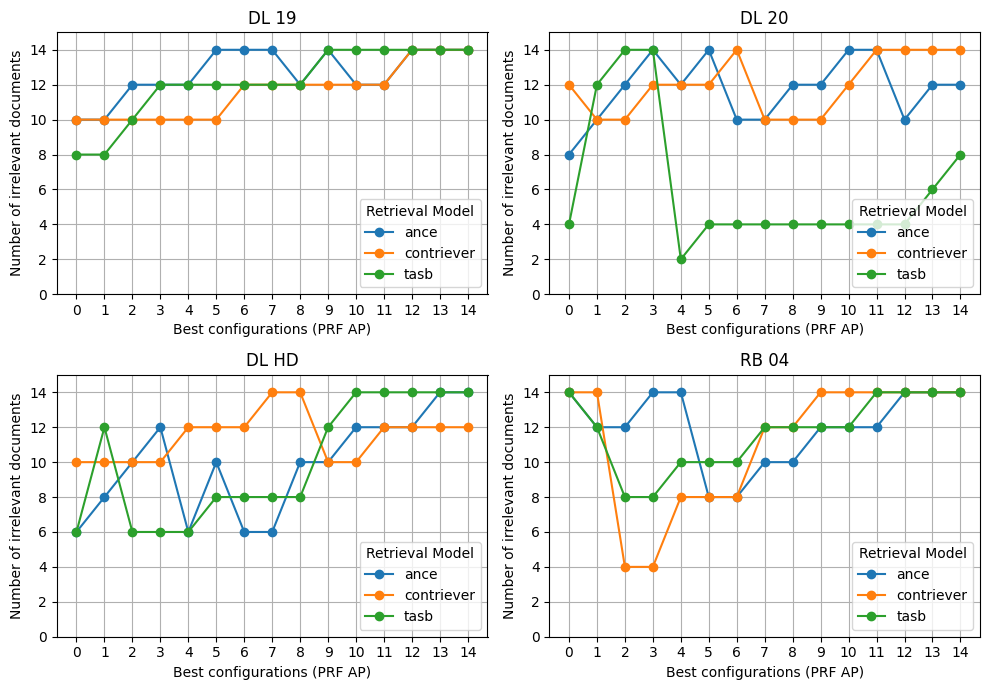

In [301]:
k = 15
grouped_data = average_perf_PRF_v0.groupby(['collection', 'retrieval_model', 'measure']).head(k).sort_index()
grouped_data

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 7))
# Loop through each retrieval model and plot their respective data
plot_data = grouped_data.xs(('deeplearning19')).xs(('AP'), level=1).droplevel([1,2]).nneg.reset_index()
for model in plot_data['retrieval_model'].unique():
    subset = plot_data[plot_data['retrieval_model'] == model].reset_index()
    axs[0,0].plot(subset.index, subset['nneg'], label=model, marker='o')

# Loop through each retrieval model and plot their respective data
plot_data = grouped_data.xs(('deeplearning20')).xs(('AP'), level=1).droplevel([1,2]).nneg.reset_index()
for model in plot_data['retrieval_model'].unique():
    subset = plot_data[plot_data['retrieval_model'] == model].reset_index()
    axs[0,1].plot(subset.index, subset['nneg'], label=model, marker='o')

# Loop through each retrieval model and plot their respective data
plot_data = grouped_data.xs(('deeplearninghd')).xs(('AP'), level=1).droplevel([1,2]).nneg.reset_index()
for model in plot_data['retrieval_model'].unique():
    subset = plot_data[plot_data['retrieval_model'] == model].reset_index()
    axs[1,0].plot(subset.index, subset['nneg'], label=model, marker='o')

# Loop through each retrieval model and plot their respective data
plot_data = grouped_data.xs(('robust04')).xs(('AP'), level=1).droplevel([1,2]).nneg.reset_index()
for model in plot_data['retrieval_model'].unique():
    subset = plot_data[plot_data['retrieval_model'] == model].reset_index()
    axs[1,1].plot(subset.index, subset['nneg'], label=model, marker='o')


# Loop through each axis to apply the common configuration
title_plots = ['DL 19', 'DL 20', 'DL HD', 'RB 04']
for i,ax in enumerate(axs.flat):
    ax.set_xlabel('Best configurations (PRF AP)')
    ax.set_ylabel('Number of irrelevant documents')
    ax.set_title(title_plots[i])
    ax.legend(title='Retrieval Model', loc='lower right')
    ax.set_ylim([0, 15])
    ax.set_xticks(range(0, k))
    ax.grid(True)

# Display the plot
plt.tight_layout()
plt.show()

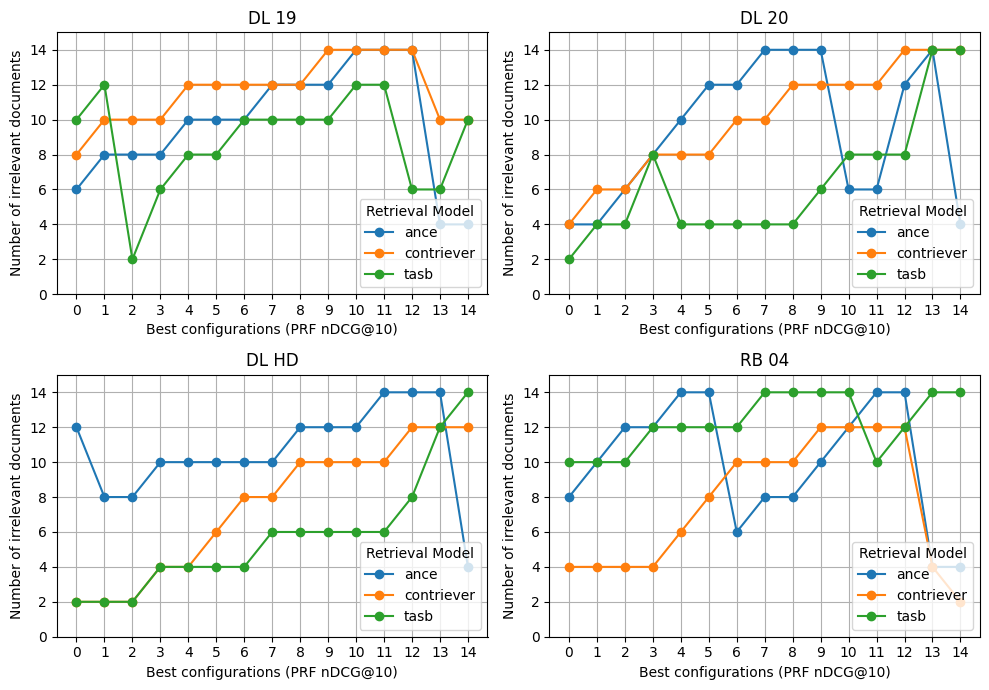

In [302]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 7))
# Loop through each retrieval model and plot their respective data
plot_data = grouped_data.xs(('deeplearning19')).xs(('nDCG@10'), level=1).droplevel([1,2]).nneg.reset_index()
for model in plot_data['retrieval_model'].unique():
    subset = plot_data[plot_data['retrieval_model'] == model].reset_index()
    axs[0,0].plot(subset.index, subset['nneg'], label=model, marker='o')

# Loop through each retrieval model and plot their respective data
plot_data = grouped_data.xs(('deeplearning20')).xs(('nDCG@10'), level=1).droplevel([1,2]).nneg.reset_index()
for model in plot_data['retrieval_model'].unique():
    subset = plot_data[plot_data['retrieval_model'] == model].reset_index()
    axs[0,1].plot(subset.index, subset['nneg'], label=model, marker='o')

# Loop through each retrieval model and plot their respective data
plot_data = grouped_data.xs(('deeplearninghd')).xs(('nDCG@10'), level=1).droplevel([1,2]).nneg.reset_index()
for model in plot_data['retrieval_model'].unique():
    subset = plot_data[plot_data['retrieval_model'] == model].reset_index()
    axs[1,0].plot(subset.index, subset['nneg'], label=model, marker='o')

# Loop through each retrieval model and plot their respective data
plot_data = grouped_data.xs(('robust04')).xs(('nDCG@10'), level=1).droplevel([1,2]).nneg.reset_index()
for model in plot_data['retrieval_model'].unique():
    subset = plot_data[plot_data['retrieval_model'] == model].reset_index()
    axs[1,1].plot(subset.index, subset['nneg'], label=model, marker='o')


# Loop through each axis to apply the common configuration
title_plots = ['DL 19', 'DL 20', 'DL HD', 'RB 04']
for i,ax in enumerate(axs.flat):
    ax.set_xlabel('Best configurations (PRF nDCG@10)')
    ax.set_ylabel('Number of irrelevant documents')
    ax.set_title(title_plots[i])
    ax.legend(title='Retrieval Model', loc='lower right')
    ax.set_ylim([0, 15])
    ax.set_xticks(range(0, k))
    ax.grid(True)

# Display the plot
plt.tight_layout()
plt.show()

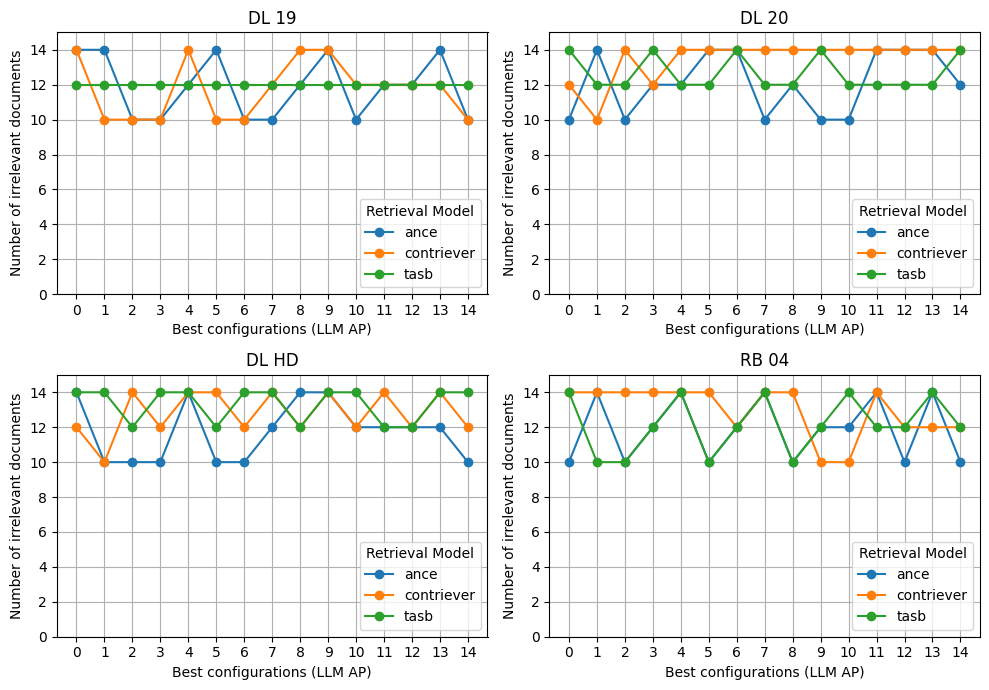

In [303]:
k = 15
grouped_data = average_perf_LLM_v0.groupby(['collection', 'retrieval_model', 'measure']).head(k).sort_index()
grouped_data

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 7))
# Loop through each retrieval model and plot their respective data
plot_data = grouped_data.xs(('deeplearning19')).xs(('AP'), level=1).droplevel([1,2]).nneg.reset_index()
for model in plot_data['retrieval_model'].unique():
    subset = plot_data[plot_data['retrieval_model'] == model].reset_index()
    axs[0,0].plot(subset.index, subset['nneg'], label=model, marker='o')

# Loop through each retrieval model and plot their respective data
plot_data = grouped_data.xs(('deeplearning20')).xs(('AP'), level=1).droplevel([1,2]).nneg.reset_index()
for model in plot_data['retrieval_model'].unique():
    subset = plot_data[plot_data['retrieval_model'] == model].reset_index()
    axs[0,1].plot(subset.index, subset['nneg'], label=model, marker='o')

# Loop through each retrieval model and plot their respective data
plot_data = grouped_data.xs(('deeplearninghd')).xs(('AP'), level=1).droplevel([1,2]).nneg.reset_index()
for model in plot_data['retrieval_model'].unique():
    subset = plot_data[plot_data['retrieval_model'] == model].reset_index()
    axs[1,0].plot(subset.index, subset['nneg'], label=model, marker='o')

# Loop through each retrieval model and plot their respective data
plot_data = grouped_data.xs(('robust04')).xs(('AP'), level=1).droplevel([1,2]).nneg.reset_index()
for model in plot_data['retrieval_model'].unique():
    subset = plot_data[plot_data['retrieval_model'] == model].reset_index()
    axs[1,1].plot(subset.index, subset['nneg'], label=model, marker='o')


# Loop through each axis to apply the common configuration
title_plots = ['DL 19', 'DL 20', 'DL HD', 'RB 04']
for i,ax in enumerate(axs.flat):
    ax.set_xlabel('Best configurations (LLM AP)')
    ax.set_ylabel('Number of irrelevant documents')
    ax.set_title(title_plots[i])
    ax.legend(title='Retrieval Model', loc='lower right')
    ax.set_ylim([0, 15])
    ax.set_xticks(range(0, k))
    ax.grid(True)

# Display the plot
plt.tight_layout()
plt.show()

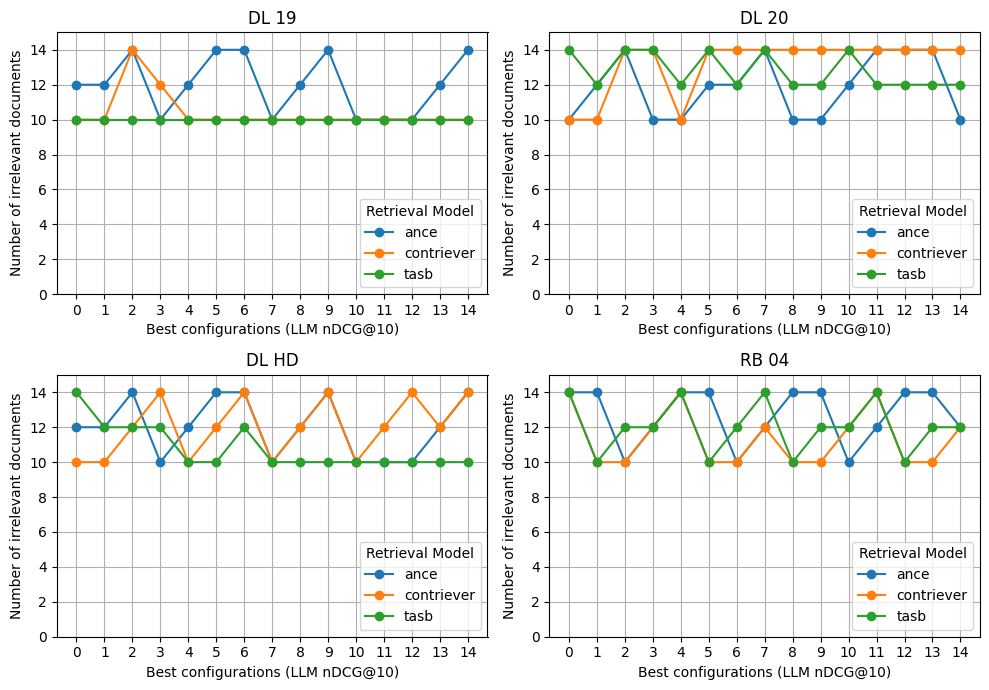

In [304]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 7))
# Loop through each retrieval model and plot their respective data
plot_data = grouped_data.xs(('deeplearning19')).xs(('nDCG@10'), level=1).droplevel([1,2]).nneg.reset_index()
for model in plot_data['retrieval_model'].unique():
    subset = plot_data[plot_data['retrieval_model'] == model].reset_index()
    axs[0,0].plot(subset.index, subset['nneg'], label=model, marker='o')

# Loop through each retrieval model and plot their respective data
plot_data = grouped_data.xs(('deeplearning20')).xs(('nDCG@10'), level=1).droplevel([1,2]).nneg.reset_index()
for model in plot_data['retrieval_model'].unique():
    subset = plot_data[plot_data['retrieval_model'] == model].reset_index()
    axs[0,1].plot(subset.index, subset['nneg'], label=model, marker='o')

# Loop through each retrieval model and plot their respective data
plot_data = grouped_data.xs(('deeplearninghd')).xs(('nDCG@10'), level=1).droplevel([1,2]).nneg.reset_index()
for model in plot_data['retrieval_model'].unique():
    subset = plot_data[plot_data['retrieval_model'] == model].reset_index()
    axs[1,0].plot(subset.index, subset['nneg'], label=model, marker='o')

# Loop through each retrieval model and plot their respective data
plot_data = grouped_data.xs(('robust04')).xs(('nDCG@10'), level=1).droplevel([1,2]).nneg.reset_index()
for model in plot_data['retrieval_model'].unique():
    subset = plot_data[plot_data['retrieval_model'] == model].reset_index()
    axs[1,1].plot(subset.index, subset['nneg'], label=model, marker='o')


# Loop through each axis to apply the common configuration
title_plots = ['DL 19', 'DL 20', 'DL HD', 'RB 04']
for i,ax in enumerate(axs.flat):
    ax.set_xlabel('Best configurations (LLM nDCG@10)')
    ax.set_ylabel('Number of irrelevant documents')
    ax.set_title(title_plots[i])
    ax.legend(title='Retrieval Model', loc='lower right')
    ax.set_ylim([0, 15])
    ax.set_xticks(range(0, k))
    ax.grid(True)

# Display the plot
plt.tight_layout()
plt.show()

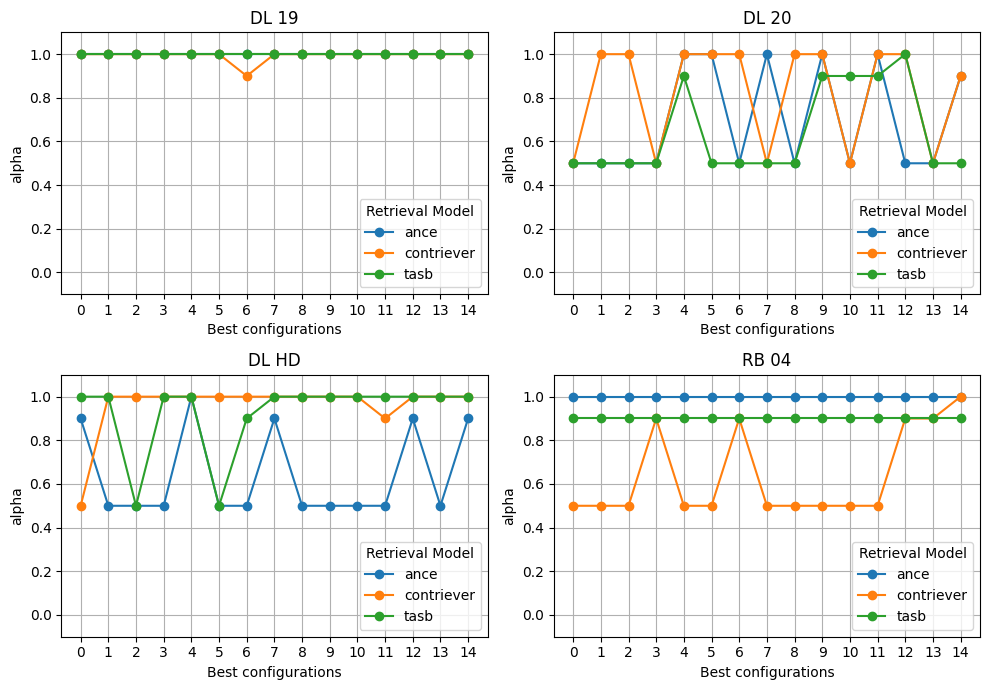

In [294]:

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 7))
# Loop through each retrieval model and plot their respective data
plot_data = grouped_data.xs(('deeplearning19')).xs(('AP'), level=1).droplevel([1,2]).a.reset_index()
for model in plot_data['retrieval_model'].unique():
    subset = plot_data[plot_data['retrieval_model'] == model].reset_index()
    axs[0,0].plot(subset.index, subset['a'], label=model, marker='o')

# Loop through each retrieval model and plot their respective data
plot_data = grouped_data.xs(('deeplearning20')).xs(('AP'), level=1).droplevel([1,2]).a.reset_index()
for model in plot_data['retrieval_model'].unique():
    subset = plot_data[plot_data['retrieval_model'] == model].reset_index()
    axs[0,1].plot(subset.index, subset['a'], label=model, marker='o')

# Loop through each retrieval model and plot their respective data
plot_data = grouped_data.xs(('deeplearninghd')).xs(('AP'), level=1).droplevel([1,2]).a.reset_index()
for model in plot_data['retrieval_model'].unique():
    subset = plot_data[plot_data['retrieval_model'] == model].reset_index()
    axs[1,0].plot(subset.index, subset['a'], label=model, marker='o')

# Loop through each retrieval model and plot their respective data
plot_data = grouped_data.xs(('robust04')).xs(('AP'), level=1).droplevel([1,2]).a.reset_index()
for model in plot_data['retrieval_model'].unique():
    subset = plot_data[plot_data['retrieval_model'] == model].reset_index()
    axs[1,1].plot(subset.index, subset['a'], label=model, marker='o')


# Loop through each axis to apply the common configuration
title_plots = ['DL 19', 'DL 20', 'DL HD', 'RB 04']
for i,ax in enumerate(axs.flat):
    ax.set_xlabel('Best configurations')
    ax.set_ylabel('alpha')
    ax.set_title(title_plots[i])
    ax.legend(title='Retrieval Model', loc='lower right')
    ax.set_ylim([-0.1, 1.1])
    ax.set_xticks(range(0, k))
    ax.grid(True)

# Display the plot
plt.tight_layout()
plt.show()

# RQ2 Figure 

In [109]:
import os
import matplotlib.pyplot as plt

def load_params(filename):
    import pickle
    with open(filename, 'rb') as handle:
        data = pickle.load(handle)
    data = pd.DataFrame(data)
    data = data[data.filtername == 'Noise1']
    return data

def read_file_v0(f):
    collection, retrieval_model, dime, _ , config_id = f.rsplit("/", 1)[1].rsplit(".")[0].split("_")
    df = pd.read_csv(f, dtype={"query_id": str})
    df[["collection", "retrieval_model", "dime"]] = collection, retrieval_model, dime + '_' + config_id
    return df

In [34]:
params  = load_params('/hdd4/giuder/progetti/DIME/data/performance/performance_cutoff/hyperparams_cutoff_1.pickle')
params['dime'] = ['Noise1' + '_' + str(id) for id, dime in enumerate(params.filtername)]

params2 = load_params('/hdd4/giuder/progetti/DIME/data/performance/performance_cutoff_giga/hyperparams.pickle')
params2['dime'] = ['Noise1' + '_' + str(id) for id, dime in enumerate(params2.filtername)]

params3 = load_params('/hdd4/giuder/progetti/DIME/data/performance/performance_cutoff_giga5k/hyperparams.pickle')
params3['dime'] = ['Noise1' + '_' + str(id) for id, dime in enumerate(params3.filtername)]

params4 = load_params('/hdd4/giuder/progetti/DIME/data/performance/performance_cutoff_giga50k/hyperparams.pickle')
params4['dime'] = ['Noise1' + '_' + str(id) for id, dime in enumerate(params4.filtername)]

params.cutoff.unique(), params2.cutoff.unique(), params3.cutoff.unique(), params4.cutoff.unique()

(array([ 100,  300,  500,  700, 1000]),
 array([   50,   500,  1000,  5000, 10000]),
 array([100, 300]),
 array([15000, 30000, 50000]))

In [141]:
params5 = load_params('/hdd4/giuder/progetti/DIME/data/performance/performance_robust04_cutoff/hyperparams.pickle')
params5['dime'] = ['Noise1' + '_' + str(id) for id, dime in enumerate(params5.filtername)]
params5.cutoff.unique()

array([   50,   300,  1000, 10000, 50000])

In [201]:
params6 = load_params('/hdd4/giuder/progetti/DIME/data/performance/performance_gpt_cutoff/hyperparams.pickle')
params6['dime'] = ['Noise1' + '_' + str(id) for id, dime in enumerate(params6.filtername)]

params7 = load_params('/hdd4/giuder/progetti/DIME/data/performance/performance_gpt_cutoff/hyperparams_ROBUST04.pickle')
params7['dime'] = ['Noise1' + '_' + str(id) for id, dime in enumerate(params7.filtername)]

params6.cutoff.unique(), params7.cutoff.unique()

(array([   50,   300,  1000, 10000, 50000]),
 array([   50,   300,  1000, 10000, 50000]))

In [28]:
def load_perf(path_to_csv):
    dimes = ['Noise1']
    measures = ['AP', 'nDCG@10']
    alphas = np.arange(0.1, 1.1, .1).round(3)

    ## retrieve all the files in the experiment folder
    fn = list(filter(lambda x: np.any([d in x for d in dimes]), glob(f"{path_to_csv}/*.csv")))
    perf = pd.concat([read_file_v0(f) for f in fn])
    perf = perf.loc[(perf.measure.isin(measures)) & (perf.alpha.isin(alphas))]

    ## average all the query for the mean_value metric
    average_perf = perf.groupby(['collection', 'retrieval_model', 'dime', 'measure', 'alpha']).value.agg('mean').reset_index()
    average_perf = average_perf.sort_values(by=['value'], ascending=False)
    return average_perf

In [144]:
## robust
average_perf_robust = load_perf('data/performance/performance_robust04_cutoff')
average_perf_robust = pd.merge(average_perf_robust, params5, on='dime', how='left').drop(columns=["measure_y","npos","nneg","a","b"]).rename(columns={'measure_x': 'measure'})

In [146]:
average_perf_K50_K1000 = load_perf('data/performance/performance_cutoff_giga')
average_perf_K50_K1000 = pd.merge(average_perf_K50_K1000, params2, on='dime', how='left')
average_perf_K50_K1000 = average_perf_K50_K1000[average_perf_K50_K1000.cutoff.isin([50,1000])].drop(columns=["measure_y","npos","nneg","a","b"]).rename(columns={'measure_x': 'measure'})
average_perf_K50_K1000 = pd.concat([average_perf_K50_K1000, average_perf_robust[average_perf_robust.cutoff.isin([50,1000])]], ignore_index=True)

average_perf_K300 = load_perf('data/performance/performance_cutoff_giga5k')
average_perf_K300 = pd.merge(average_perf_K300, params3, on='dime', how='left')
average_perf_K300 = average_perf_K300[average_perf_K300.cutoff==300].drop(columns=["measure_y","npos","nneg","a","b"]).rename(columns={'measure_x': 'measure'})
average_perf_K300 = pd.concat([average_perf_K300, average_perf_robust[average_perf_robust.cutoff.isin([300])]], ignore_index=True)

average_perf_K50k = load_perf('data/performance/performance_cutoff_giga50k')
average_perf_K50k = pd.merge(average_perf_K50k, params4, on='dime', how='left')
average_perf_K50k = average_perf_K50k[average_perf_K50k.cutoff==50000].drop(columns=["measure_y","npos","nneg","a","b"]).rename(columns={'measure_x': 'measure'})
average_perf_K50k = pd.concat([average_perf_K50k, average_perf_robust[average_perf_robust.cutoff.isin([50000])]], ignore_index=True)


In [202]:
average_perf_LLM = load_perf('data/performance/performance_gpt_cutoff')
average_perf_LLM1 = pd.merge(average_perf_LLM[average_perf_LLM.collection!='robust04'], params6, on='dime', how='left')
average_perf_LLM2 = pd.merge(average_perf_LLM[average_perf_LLM.collection=='robust04'], params7, on='dime', how='left')
average_perf_LLM = pd.concat([average_perf_LLM1, average_perf_LLM2], ignore_index=True).drop(columns=["measure_y","npos","nneg","a","b"]).rename(columns={'measure_x': 'measure'})

In [147]:
def visualize_best_configurations(data, k=5):
    '''return the best k configuration'''
    grouped_data = data.groupby(['collection', 'retrieval_model',  'measure']).head(k)
    grouped_data = grouped_data.set_index(['collection', 'retrieval_model',  'measure']).sort_index()
    return grouped_data

k=1

def compute_filename(folder_path, tupla):
    _, collection, retrieval_model, measure, dime = tupla
    dime, config = dime.split('_')
    filepath = f"{collection}_{retrieval_model}_Noise1_{measure}_{config}.csv"
    return os.path.join(folder_path, filepath)

def over_copy(src, dst):
    try:
        shutil.copyfile(src, dst)
    except shutil.SameFileError:
        pass

In [204]:
def copy_file(data, source_folder, output_folder):
    instruction = visualize_best_configurations(data, 1).reset_index()[['collection', 'retrieval_model', 'measure', 'dime']].to_records('index')
    for instr in instruction: 
        #if instr[1] == 'robust04':
        #    source_folder='data/performance/performance_robust04_cutoff'
        fn = compute_filename(source_folder, instr)
        out_fn = compute_filename(output_folder, instr)
        over_copy(fn, out_fn)
    return 

#copy_file(average_perf_K50_K1000[average_perf_K50_K1000.cutoff.isin([50])], source_folder = 'data/performance/performance_cutoff_giga', output_folder = 'data/experiments_finale/best_results_update/rq2-sampling/k50')
#copy_file(average_perf_K50_K1000[average_perf_K50_K1000.cutoff.isin([1000])], source_folder = 'data/performance/performance_cutoff_giga', output_folder = 'data/experiments_finale/best_results_update/rq2-sampling/k1000')
#copy_file(average_perf_K300[average_perf_K300.cutoff.isin([300])], source_folder = 'data/performance/performance_cutoff_giga5k', output_folder = 'data/experiments_finale/best_results_update/rq2-sampling/k300')
#copy_file(average_perf_K50k[average_perf_K50k.cutoff.isin([50000])], source_folder = 'data/performance/performance_cutoff_giga50k', output_folder = 'data/experiments_finale/best_results_update/rq2-sampling/k50000')

In [205]:
copy_file(average_perf_LLM[average_perf_LLM.cutoff.isin([50])], source_folder = 'data/performance/performance_gpt_cutoff', output_folder = 'data/experiments_finale/best_results_update/rq2-sampling-llm/k50')
copy_file(average_perf_LLM[average_perf_LLM.cutoff.isin([1000])], source_folder = 'data/performance/performance_gpt_cutoff', output_folder = 'data/experiments_finale/best_results_update/rq2-sampling-llm/k1000')
copy_file(average_perf_LLM[average_perf_LLM.cutoff.isin([300])], source_folder = 'data/performance/performance_gpt_cutoff', output_folder = 'data/experiments_finale/best_results_update/rq2-sampling-llm/k300')
copy_file(average_perf_LLM[average_perf_LLM.cutoff.isin([50000])], source_folder = 'data/performance/performance_gpt_cutoff', output_folder = 'data/experiments_finale/best_results_update/rq2-sampling-llm/k50000')

In [206]:
def load_cutoff(collection_name, metric, retrieval_model, path_to_folder = 'data/experiments_finale/best_results_update/rq2-sampling'):
    out = []
    for size in [50, 300, 1000, 50000]:
        files = list(filter(lambda x: (collection_name in x) & (metric in x) & (retrieval_model in x), glob(f"{path_to_folder}/k{size}/*.csv")))
        perf = pd.concat([read_file_v0(f) for f in files])
        ## average all the query for the mean_value metric
        average_perf = perf.groupby(['collection', 'retrieval_model', 'dime', 'measure', 'alpha']).value.agg('mean').reset_index()
        average_perf = average_perf.sort_values(by=['value'], ascending=False).reset_index()
        average_perf.loc[:, 'D_size'] = size
        out.append(average_perf)
    
    out = pd.concat(out, ignore_index=True).drop(columns=['index'])
    out.sort_values(by=['D_size', 'alpha'], inplace=True)
    return out[['alpha', 'value', 'D_size']]

In [207]:
from matplotlib.ticker import FuncFormatter
formatter = FuncFormatter(lambda x, _: f'{x:.2f}')

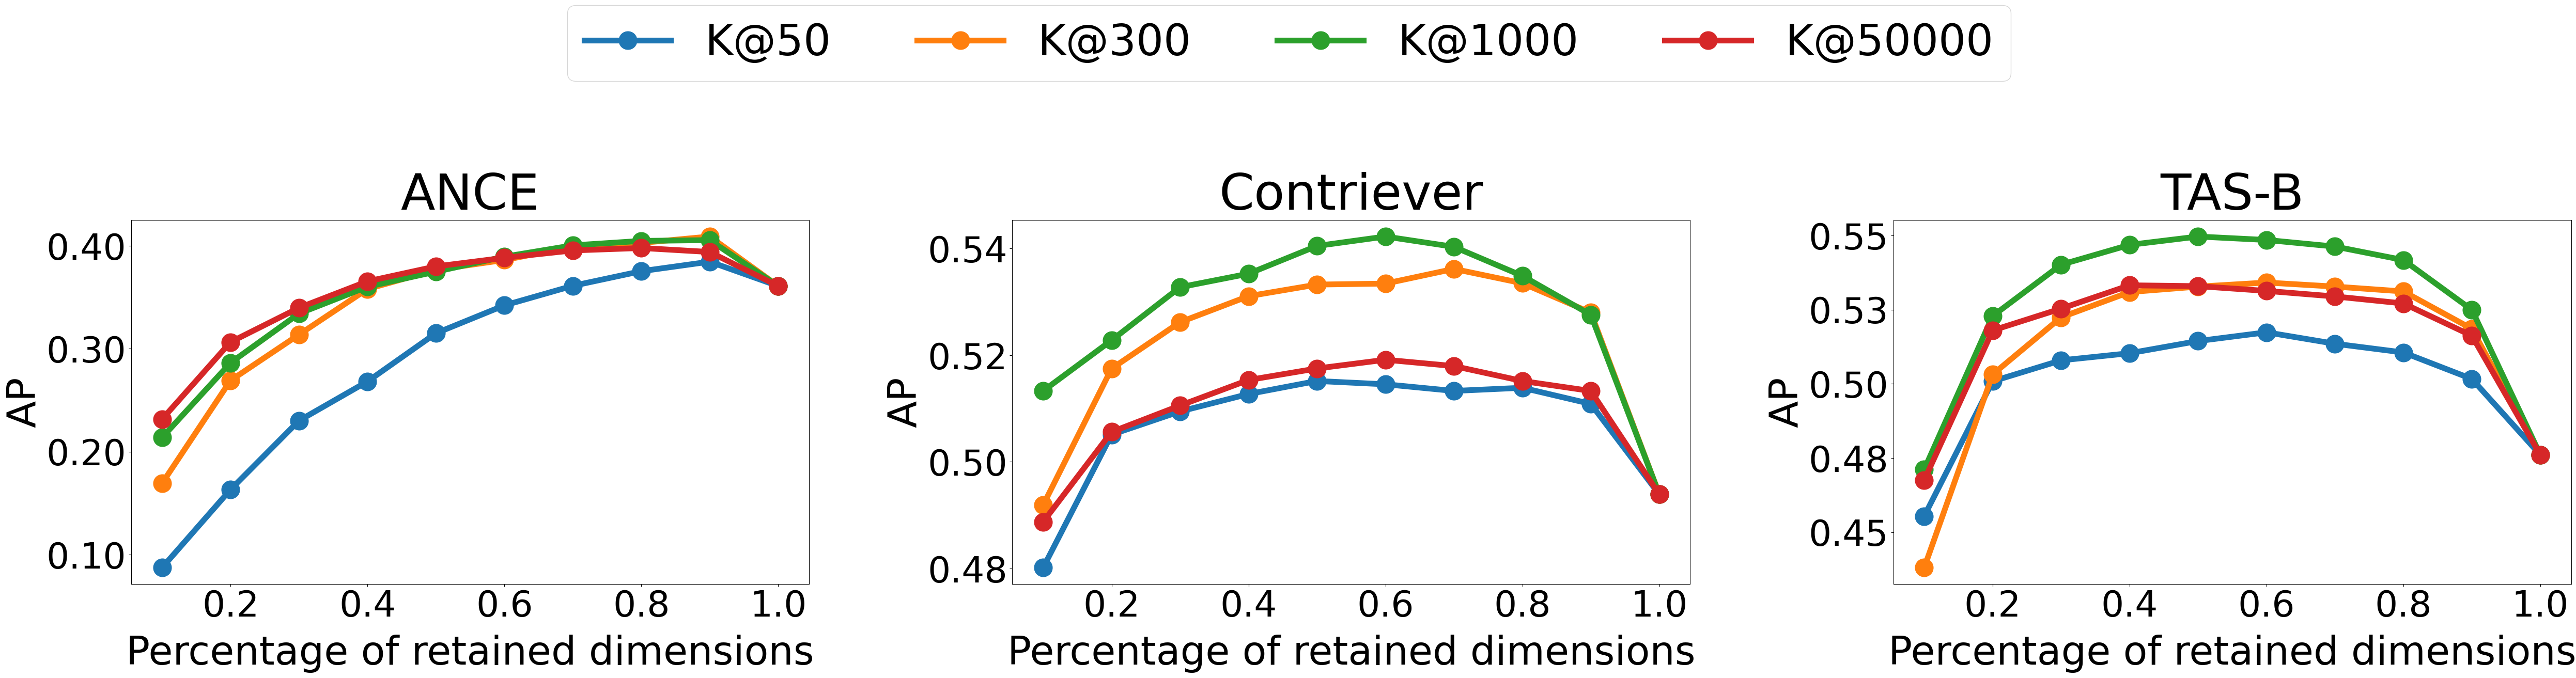

In [265]:
fig, axs = plt.subplots(1, 3, figsize = (50, 10))

retr_models = ['ance', 'contriever', 'tasb']
models_names = ['ANCE', 'Contriever', 'TAS-B']
for i, retr_model in enumerate(retr_models):
    df = load_cutoff('deeplearning19', 'AP', retr_model)
    # Loop through each unique value of D and plot a separate curve
    for d_value in df['D_size'].unique():
        subset = df[df['D_size'] == d_value]
        axs[i].plot(subset['alpha'], subset['value'], marker='o', label=f'K@{d_value}', lw=8, markersize=25)

        # Adding plot labels and title
        axs[i].set_xlabel('Percentage of retained dimensions', fontsize = 55, labelpad=15)
        axs[i].set_ylabel('AP', fontsize = 55)
        axs[i].set_title(models_names[i], fontsize = 70)
        #axs[i].legend()
        axs[i].tick_params(axis='x', labelsize=50)
        axs[i].tick_params(axis='y', labelsize=50)

# Apply the formatter to each subplot
for ax in axs:
    ax.yaxis.set_major_formatter(formatter)

# Extract the handles and labels from one of the subplots (e.g., the first one)
handles, labels = axs[0].get_legend_handles_labels()
# Create a single legend at the top of the figure using the extracted handles and labels

fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.35), ncol=4, frameon=True, fontsize=60)
fig.tight_layout()
plt.subplots_adjust(wspace=0.3)

filename = 'DL19_AP_RQ2.pdf'
fig.savefig(f'data/experiments_finale/best_results_update/rq2-sampling/{filename}', dpi=300, bbox_inches='tight')

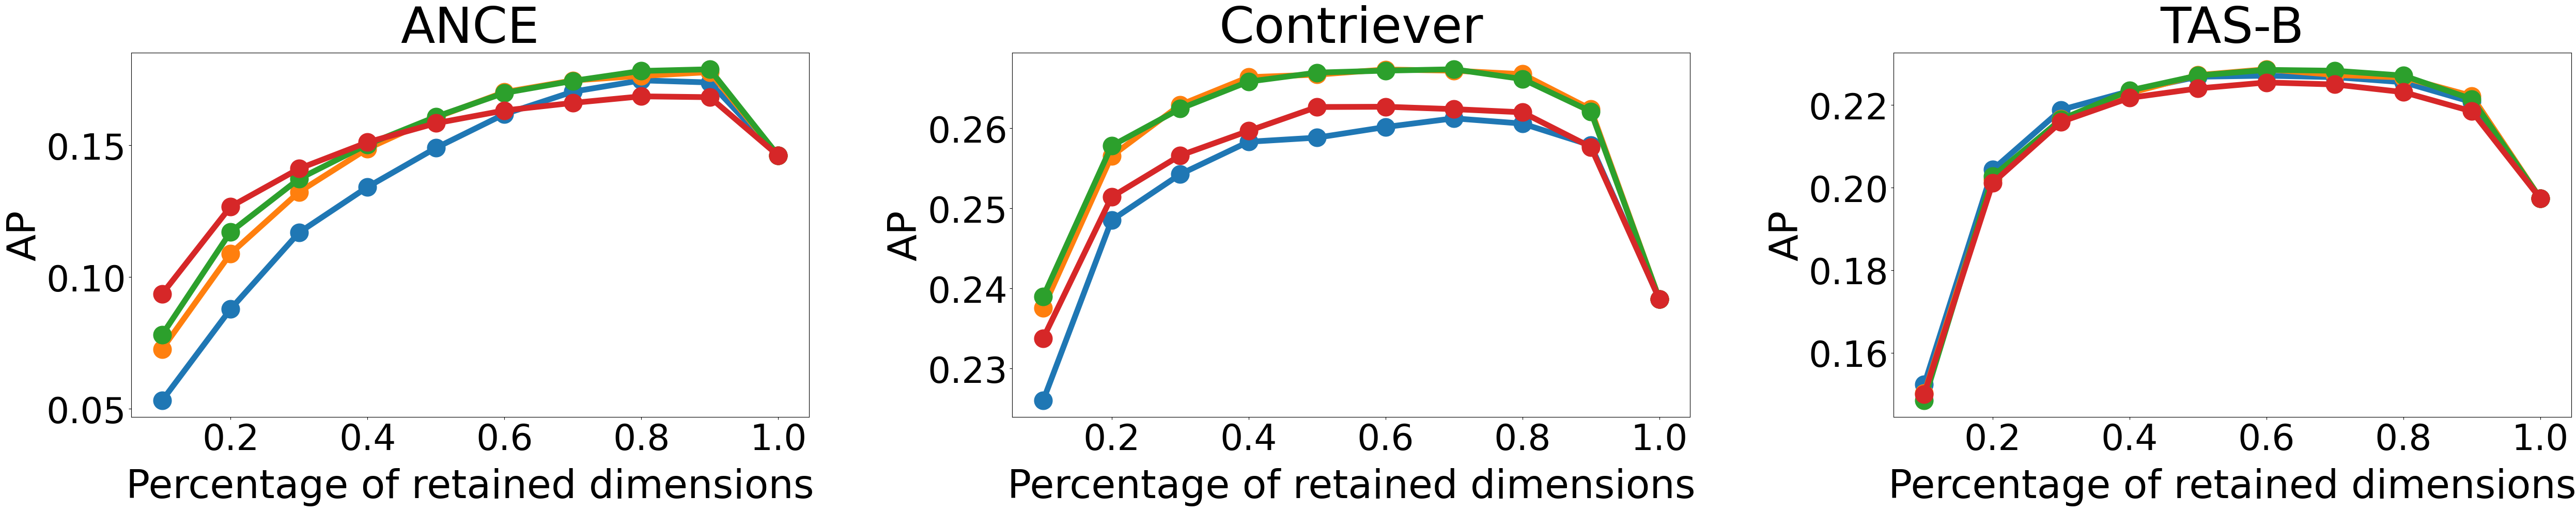

In [266]:
fig, axs = plt.subplots(1, 3, figsize = (50, 10))

retr_models = ['ance', 'contriever', 'tasb']
models_names = ['ANCE', 'Contriever', 'TAS-B']
for i, retr_model in enumerate(retr_models):
    df = load_cutoff('robust04', 'AP', retr_model)
    # Loop through each unique value of D and plot a separate curve
    for d_value in df['D_size'].unique():
        subset = df[df['D_size'] == d_value]
        axs[i].plot(subset['alpha'], subset['value'], marker='o', label=f'K@{d_value}', lw=8, markersize=25)

        # Adding plot labels and title
        axs[i].set_xlabel('Percentage of retained dimensions', fontsize = 55, labelpad=15)
        axs[i].set_ylabel('AP', fontsize = 55)
        axs[i].set_title(models_names[i], fontsize = 70)
        #axs[i].legend()
        axs[i].tick_params(axis='x', labelsize=50)
        axs[i].tick_params(axis='y', labelsize=50)

# Apply the formatter to each subplot
for ax in axs:
    ax.yaxis.set_major_formatter(formatter)

# Extract the handles and labels from one of the subplots (e.g., the first one)
handles, labels = axs[0].get_legend_handles_labels()
# Create a single legend at the top of the figure using the extracted handles and labels

#fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.35), ncol=4, frameon=True, fontsize=60)
fig.tight_layout()
plt.subplots_adjust(wspace=0.3)

filename = 'RB04_AP_RQ2.pdf'
fig.savefig(f'data/experiments_finale/best_results_update/rq2-sampling/{filename}', dpi=300, bbox_inches='tight')

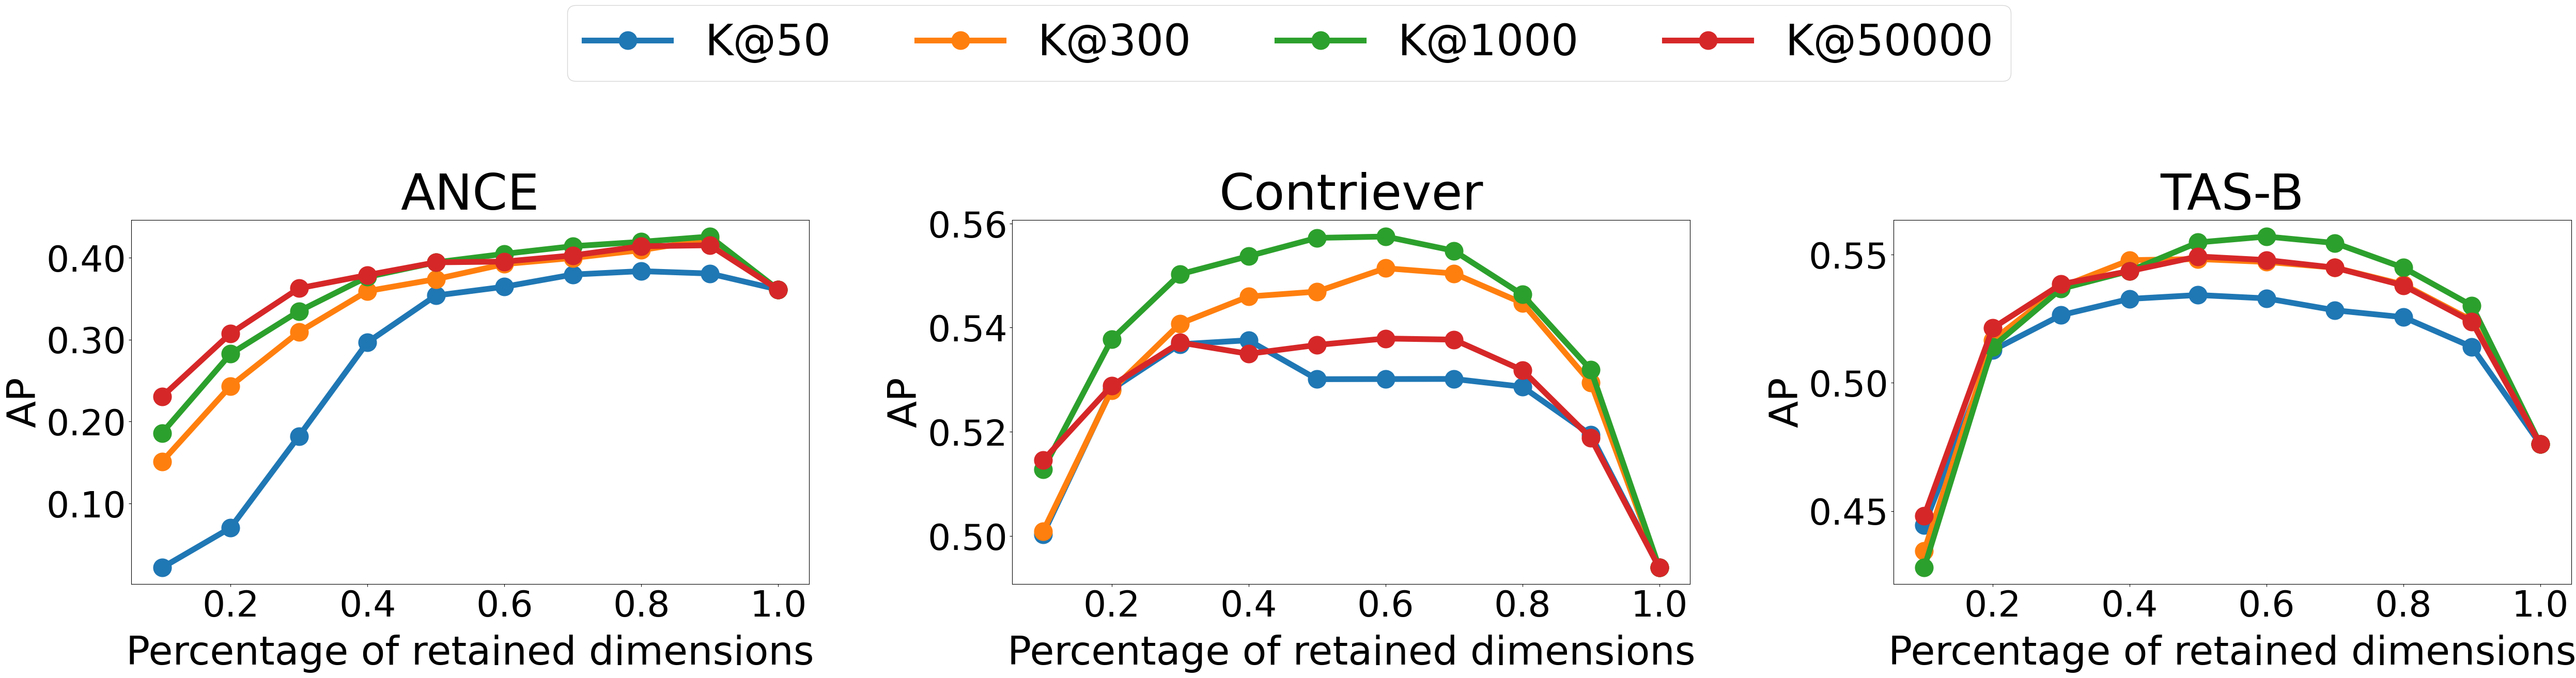

In [267]:
fig, axs = plt.subplots(1, 3, figsize = (50, 10))

retr_models = ['ance', 'contriever', 'tasb']
models_names = ['ANCE', 'Contriever', 'TAS-B']
for i, retr_model in enumerate(retr_models):
    df = load_cutoff('deeplearning19', 'AP', retr_model, path_to_folder = 'data/experiments_finale/best_results_update/rq2-sampling-llm')
    # Loop through each unique value of D and plot a separate curve
    for d_value in df['D_size'].unique():
        subset = df[df['D_size'] == d_value]
        axs[i].plot(subset['alpha'], subset['value'], marker='o', label=f'K@{d_value}', lw=8, markersize=25)

        # Adding plot labels and title
        axs[i].set_xlabel('Percentage of retained dimensions', fontsize = 55, labelpad=15)
        axs[i].set_ylabel('AP', fontsize = 55)
        axs[i].set_title(models_names[i], fontsize = 70)
        #axs[i].legend()
        axs[i].tick_params(axis='x', labelsize=50)
        axs[i].tick_params(axis='y', labelsize=50)

# Apply the formatter to each subplot
for ax in axs:
    ax.yaxis.set_major_formatter(formatter)

# Extract the handles and labels from one of the subplots (e.g., the first one)
handles, labels = axs[0].get_legend_handles_labels()
# Create a single legend at the top of the figure using the extracted handles and labels

fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.35), ncol=4, frameon=True, fontsize=60)
fig.tight_layout()
plt.subplots_adjust(wspace=0.3)

filename = 'LLM_DL19_AP_RQ2.pdf'
fig.savefig(f'data/experiments_finale/best_results_update/rq2-sampling-llm/{filename}', dpi=300, bbox_inches='tight')

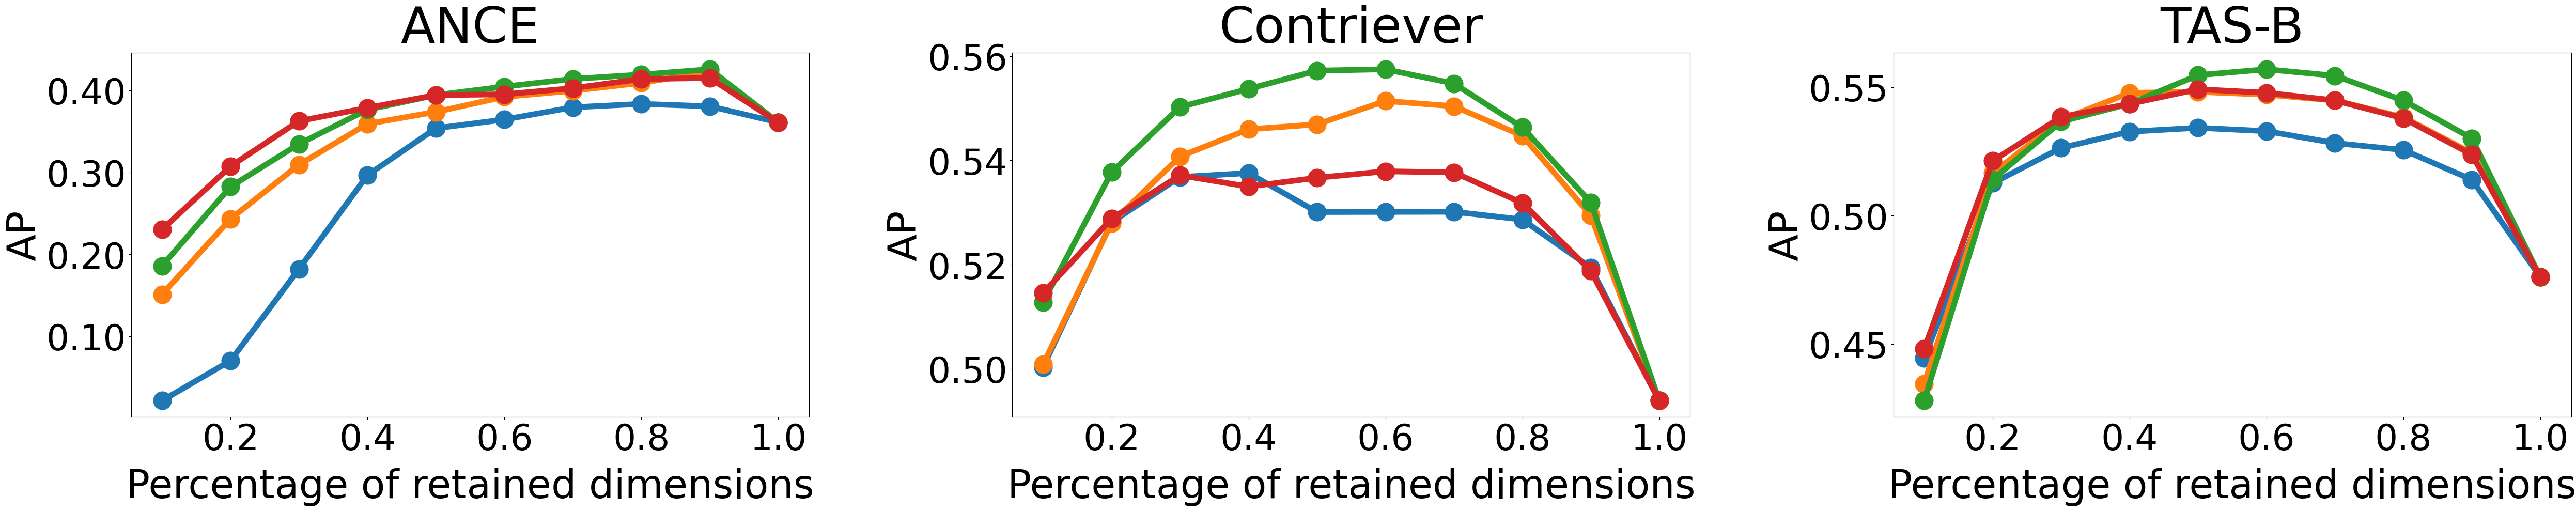

In [268]:
fig, axs = plt.subplots(1, 3, figsize = (50, 10))

retr_models = ['ance', 'contriever', 'tasb']
models_names = ['ANCE', 'Contriever', 'TAS-B']
for i, retr_model in enumerate(retr_models):
    df = load_cutoff('deeplearning19', 'AP', retr_model, path_to_folder = 'data/experiments_finale/best_results_update/rq2-sampling-llm')
    # Loop through each unique value of D and plot a separate curve
    for d_value in df['D_size'].unique():
        subset = df[df['D_size'] == d_value]
        axs[i].plot(subset['alpha'], subset['value'], marker='o', label=f'K@{d_value}', lw=8, markersize=25)

        # Adding plot labels and title
        axs[i].set_xlabel('Percentage of retained dimensions', fontsize = 55, labelpad=15)
        axs[i].set_ylabel('AP', fontsize = 55)
        axs[i].set_title(models_names[i], fontsize = 70)
        #axs[i].legend()
        axs[i].tick_params(axis='x', labelsize=50)
        axs[i].tick_params(axis='y', labelsize=50)

# Apply the formatter to each subplot
for ax in axs:
    ax.yaxis.set_major_formatter(formatter)

# Extract the handles and labels from one of the subplots (e.g., the first one)
handles, labels = axs[0].get_legend_handles_labels()
# Create a single legend at the top of the figure using the extracted handles and labels

#fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.35), ncol=4, frameon=True, fontsize=60)
fig.tight_layout()
plt.subplots_adjust(wspace=0.3)

filename = 'LLM_RB04_AP_RQ2.pdf'
fig.savefig(f'data/experiments_finale/best_results_update/rq2-sampling-llm/{filename}', dpi=300, bbox_inches='tight')